# Projet 5 : Segmentez des clients d'un site e-commerce

### Brazilian E-Commerce Public Dataset by Olist

Le jeu de données comporte 100k commandes de 2016 à 2018 chez plusieurs enseignes au Brésil.
Les données renseignent les informations suivantes : prix, évaluation, nombre d'articles, poids, description, géolocalisation... 


#### Objectifs :

- Comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles

- Fournir à Olist, une segmentation de ses clients avec une description actionable de cette segmantation et sa logique sous-jacente

- Fournir à Olist, une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps



Pour plus d'informations sur les données : https://www.kaggle.com/olistbr/brazilian-ecommerce

#### Segmentation RFM :

RFM est un acronyme pour Recence, Fréquence et Montant. 

- Récence indique la date du dernier achat. Il s'agit du nombre de jours depuis la dernière commande d'un client. 


- Fréquence est le nombre d'achat sur une période déterminé. Cela peut être 3 mois, 6 mois ou un 1 an. Elle indique la fidélité d'un client, plus sa valeur est élevé et plus le client est engagé.


- Montant est la somme totale qu'un client dépense sur une période donnée


<img src="rfm.png">

#### Methodologie 1 :

- 1. Calcul des variables R, F et M
- 2. Quantiliser chaque variable R, F et M puis attribuer la note associé de 1 à 5 pour chaque client et pour chaque variable
- 3. Segmenter des groupes d'individus en fonction de leurs notes pour chaque variable R, F et M
- 4. Etiquetter chaque segment


#### Méthodologie 2 :

- 1. Calcul des variables R, F et M 
- 2. Les variables R, F et M sont normalisés 
- 3. Utiliser un algorithme de clusterisation sur les données normalisés
- 4. Etiquetter chaque cluster obtenu





#### Stabilité de la segmentation

Pour chaque méthodologie étudié, une période est séléctionné pour la segmentation/clusterisation, puis une autre période sera testé pour évaluer la stabilité de la segmentation obtenue par la méthodologie étudié.

#### Chargement des librairies

In [1]:
# Librairies graphiques, mathématiques et de manipulation de données
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from math import pi
import plotly.graph_objects as go

# Création de Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

# Transformateurs de variables
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Méthodes de clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Metrics de Clustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score

#%load_ext pycodestyle_magic

#### Lecture des données

In [2]:
# Chemin d'accès aux données
path = "data/"

# Infos sur la géolocalisation
geo = pd.read_csv(os.path.join(path, "olist_geolocation_dataset.csv"))
# Infos sur les payments
payments = pd.read_csv(os.path.join(path, "olist_order_payments_dataset.csv"))
# Infos sur les achats
orders = pd.read_csv(os.path.join(path, "olist_orders_dataset.csv"))
# Infos sur les produits
products = pd.read_csv(os.path.join(path, "olist_products_dataset.csv"))
# Infos sur les vendeurs
sellers = pd.read_csv(os.path.join(path, "olist_sellers_dataset.csv"))
# Infos sur les clients
customers = pd.read_csv(os.path.join(path, "olist_customers_dataset.csv"))
# Infos sur l'évaluation des produits
reviews = pd.read_csv(os.path.join(path, "olist_order_reviews_dataset.csv"))
# Infos sur les items
items = pd.read_csv(os.path.join(path, "olist_order_items_dataset.csv"))
# Infos sur les catégories des produits
category = pd.read_csv(os.path.join(path, "product_category_name_translation.csv"))

FileNotFoundError: [Errno 2] File b'data/olist_geolocation_dataset.csv' does not exist: b'data/olist_geolocation_dataset.csv'

## 1. Description et visualisation des données

### 1.1 Données géographiques

#### 1.1.1 Apperçu des données

In [ ]:
# Apperçu des 5 premières lignes
geo.head()

#### 1.1.1 Structure des données

In [ ]:
# Structure des données
geo.info()

#### 1.1.2 Visualisation géographique

In [ ]:
# Removing some outliers
# Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude
geo = geo[geo.geolocation_lat <= 5.27438888]
# it’s most Western spot is at 73 deg, 58′ 58.19″W Long
geo = geo[geo.geolocation_lng >= -73.98283055]
# It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude
geo = geo[geo.geolocation_lat >= -33.75116944]
# It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <= -34.79314722]

In [ ]:
# Apperçu des 5 premières lignes
geo.head()

In [ ]:
geo.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat",
         alpha=0.4, c="geolocation_zip_code_prefix",
         cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10, 10))
plt.show()

### 1.2 Données sur les payments

#### 1.2.1 Apperçu des données

In [ ]:
# Apperçu des 5 premières lignes
payments.head()

#### 1.2.2 Structure et description des données

In [ ]:
# Structure des données
payments.info()

In [ ]:
# Description des données
payments.describe()

#### 1.2.3 Analyse graphique des données

In [ ]:
fig = plt.figure(1, figsize=(8, 4))
# Histogramme de "payment_value"
plt.subplot(1, 2, 1)
sns.distplot(payments["payment_value"])
plt.style.use('ggplot')

# Boxplot de "payment_value"
plt.subplot(1, 2, 2)
sns.boxplot(payments["payment_value"], showfliers=False)
plt.show()

- Le payement median est de 100 R$

In [ ]:
# Nombre de valeurs par type de paiements
payments["payment_type"].value_counts()

Suppresion des payments "not_defined"

In [3]:
# On supprime les paiements de type "not_defined"
payment_type = ["credit_card", "boleto", "voucher", "debit_card"]
payments = payments[payments["payment_type"].isin(payment_type)]

NameError: name 'payments' is not defined

NameError: name 'payments' is not defined

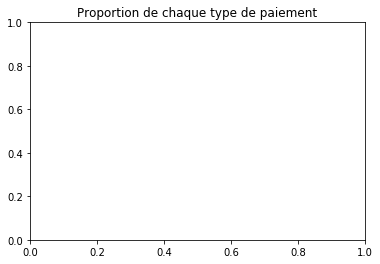

In [4]:
# Pieplot des différents moyens de paiements
plt.title("Proportion de chaque type de paiement")
fig = plt.figure(1, figsize=(8, 8))
plt.pie(payments["payment_type"].value_counts(),
        labels=payments["payment_type"].unique(), shadow=True)
plt.show()

Boxplot des montant des payements en fonction du type de payement

NameError: name 'payments' is not defined

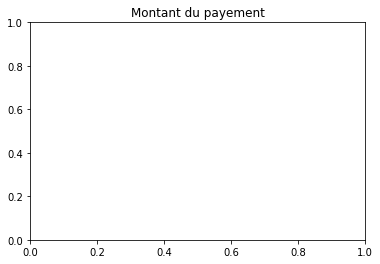

In [5]:
# Boxplot pour chaque type de paiement
plt.title("Montant du payement")
sns.boxplot(data=payments, y="payment_value",
            x="payment_type", showfliers=False)
plt.show()

- Voucher signifie bon d'achats, le payement moyen par ce type de payment est plus faible que les autres

- Boleto est un moyen de payment en espèce

In [16]:
# Nombre moyen de paiements par type de paiement
payments.groupby("payment_type").mean()["payment_installments"]

payment_type
boleto         1.000000
credit_card    3.507155
debit_card     1.000000
voucher        1.000000
Name: payment_installments, dtype: float64

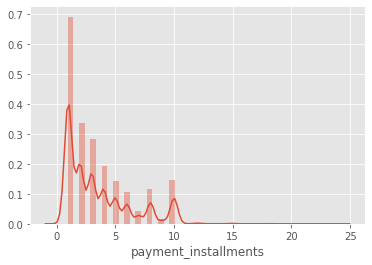

In [17]:
# Densité du nombre de paiements pour
# tous les paiements effectués par carte de crédit
credit_card = payments[payments["payment_type"] == "credit_card"]
sns.distplot(credit_card["payment_installments"])
plt.show()

- Le nombre moyen de payments est majoritairement égale à 1

### 1.3 Données sur les "items"

#### 1.3.1 Apperçu des données

In [18]:
# Affichage des 5 premières lignes
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


#### 1.3.2 Structure et description des données

In [19]:
# Structure des données
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null object
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [20]:
# Description des données
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


- order_item_id est le nombre d'objets dans une même commande

- freight_value est le coût de livraison

- shipping_limit_date correspond à la date d'expédition auprès du transporteur

#### 1.3.3 Analyse graphique des données

#### Nombre d'articles dans une même commande

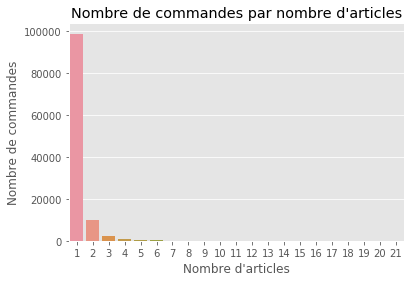

In [21]:
# Nombre d'articles dans une même commande
x = list(items["order_item_id"].value_counts().index)
y = items["order_item_id"].value_counts().values

plt.title("Nombre de commandes par nombre d'articles")
plt.xlabel("Nombre d'articles")
plt.ylabel("Nombre de commandes")
sns.barplot(x, y)
plt.show()

- La plus grande majorité des commande comporte un seul article

#### Prix et coûts de transport des marchandises

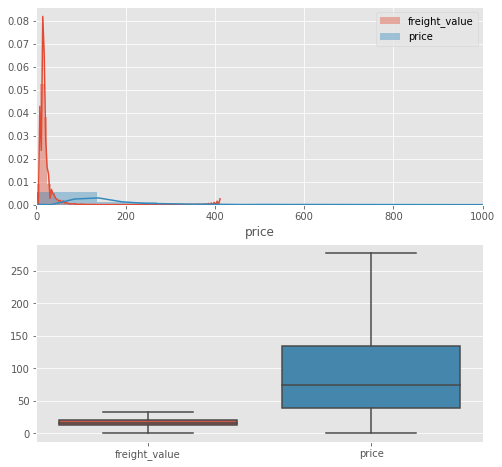

In [22]:
fig = plt.figure(1, figsize=(8, 8))

# Histogramme freight value et prix
plt.subplot(211)
sns.distplot(items["freight_value"], label="freight_value")
sns.distplot(items["price"], label="price")
plt.legend()
# x-axis limits
plt.xlim([0, 1000])

# Boxplot freight value et prix
plt.subplot(212)
sns.boxplot(data=items, order=["freight_value", "price"], showfliers=False)
plt.show()

### 1.4 Données sur les vendeurs

#### 1.4.1 Apperçu des données

In [23]:
# Affichage des 5 premières lignes
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


#### 1.4.2 Nombre de villes et d'Etats

In [24]:
# Nombre de villes
Number_of_cities = sellers["seller_city"].nunique()
# Nombre d'Etats
Number_of_states = sellers["seller_state"].nunique()
print("Le nombre de villes est : {}".format(Number_of_cities))
print("Le nombre d'états est : {}".format(Number_of_states))

Le nombre de villes est : 611
Le nombre d'états est : 23


### 1.5 Données sur les acheteurs

#### 1.5.1 Apperçu des données

In [25]:
# Affichage des 5 premières lignes
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [26]:
# Structure des données
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### 1.5.2 Nombre de villes et d'Etats

In [27]:
# Nombre de villes
Number_of_cities = customers["customer_city"].nunique()
# Nombre d'Etats
Number_of_states = customers["customer_state"].nunique()
# Nombre de consommateurs
Number_of_customers = customers["customer_unique_id"].nunique()

print("Le nombre de villes est : {}".format(Number_of_cities))
print("Le nombre d'états est : {}".format(Number_of_states))
print("Le nombre de clients est : {}".format(Number_of_customers))

Le nombre de villes est : 4119
Le nombre d'états est : 27
Le nombre de clients est : 96096


### 1.6 Données sur les catégories des produits

In [28]:
# Affichage des 5 premières lignes
category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [29]:
# Structure des données
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
product_category_name            71 non-null object
product_category_name_english    71 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


In [30]:
print("Le nombre de catégories est de : {}"
      .format(category["product_category_name_english"].nunique()))

Le nombre de catégories est de : 71


### 1.7 Données sur l'évaluation des produits par les clients

In [31]:
# Affichage des 5 premières lignes
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [32]:
# Structure des données
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
review_id                  100000 non-null object
order_id                   100000 non-null object
review_score               100000 non-null int64
review_comment_title       11715 non-null object
review_comment_message     41753 non-null object
review_creation_date       100000 non-null object
review_answer_timestamp    100000 non-null object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


#### Visualisation du délai d'évaluation des produits

In [33]:
# Conversion des données dates en datetime
review_answer_timestamp = pd.to_datetime(reviews["review_answer_timestamp"])
review_creation_date = pd.to_datetime(reviews["review_creation_date"])
# Délai d'évaluation des produits
review_answer = review_answer_timestamp - review_creation_date
# Converti en secondes
review_answer = review_answer.dt.total_seconds()/(3600*24)
reviews["Delay_to_answer"] = review_answer

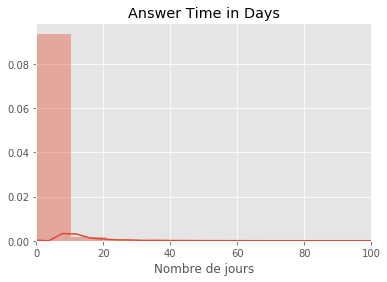

In [34]:
# Histogramme du délai d'évaluation des produits
sns.distplot(review_answer, label="Answer Time")
plt.xlim([0, 100])
plt.xlabel("Nombre de jours")
plt.title("Answer Time in Days")
plt.show()

### 1.8 Données sur les produits

#### 1.8.1 Apperçu des données

In [35]:
# Affichage des 5 premières lignes
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [36]:
# Structure des données
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32341 non-null float64
product_description_lenght    32341 non-null float64
product_photos_qty            32341 non-null float64
product_weight_g              32949 non-null float64
product_length_cm             32949 non-null float64
product_height_cm             32949 non-null float64
product_width_cm              32949 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### 1.8.2 Description des variables numériques

In [37]:
# Description des données
products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


#### 1.8.3 Affiche de la matrice de corrélation

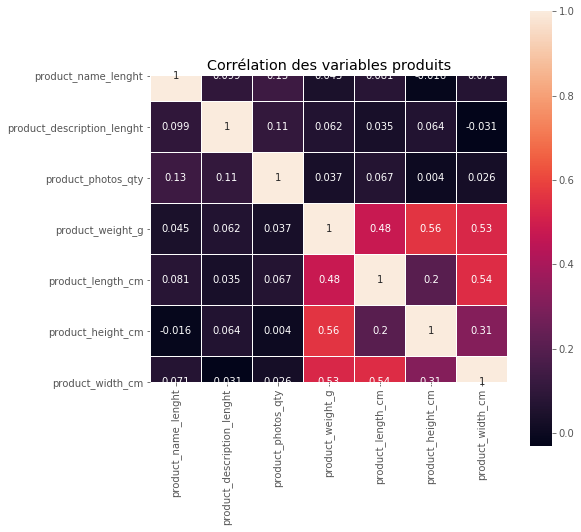

In [38]:
# Matrice de corrélation
matrix_corr = products.corr()
fig = plt.figure(1, figsize=(8, 8))
# Heatmap de la matrice de corrélation
sns.heatmap(matrix_corr, square=True, linewidths=0.1, annot=True)
plt.title("Corrélation des variables produits")
plt.show()

- Le poids est évidemment corrélé aux dimensions du produit et donc du volume

In [39]:
# Nombre de catégories
print("Le nombre de catégories est : {}"
      .format(products["product_category_name"].nunique()))

Le nombre de catégories est : 73


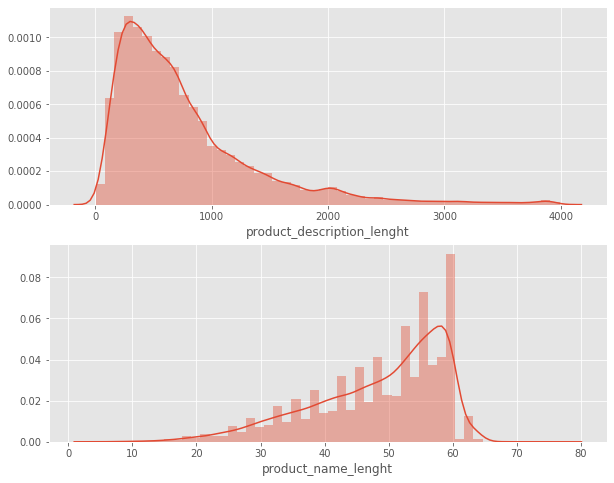

In [40]:
# Longueur de la description des produits
descr_nnull = products[~products["product_description_lenght"].isna()]
fig = plt.figure(1, figsize=(10, 8))
ax1 = fig.add_subplot(211)
sns.distplot(descr_nnull["product_description_lenght"], ax=ax1)
# Longueur du nom du produit
ax2 = fig.add_subplot(212)
sns.distplot(descr_nnull["product_name_lenght"], ax=ax2)

plt.show()

### 1.9 Données sur les achats

#### 1.9.1 Apperçu des données

In [41]:
# Affichage des 5 premières lignes
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [42]:
# Affiche la structure du df
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


- order_delivered_carrier_date correspond à la date à laquelle la commande a été remise au transporteur


#### 1.9.2 Status d'achat

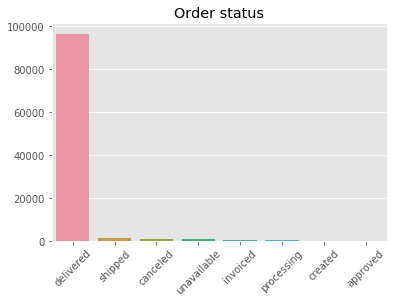

In [43]:
# Nombre de commandes par statuts d'achats
order_status = orders["order_status"].value_counts()
sns.barplot(x=order_status.index, y=order_status.values)
plt.title("Order status")
plt.xticks(rotation=45)
plt.show()

#### 1.9.3 Délai de livraison

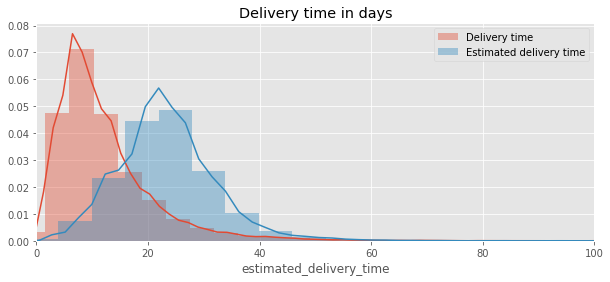

In [44]:
# Conversion des données dates en datetime
orders['order_approved_at'] = pd.to_datetime(
    orders['order_approved_at'])
orders['order_estimated_delivery_date'] = pd.to_datetime(
    orders['order_estimated_delivery_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'])

# Calculate differences in hours
orders['delivery_time'] = orders['order_delivered_customer_date'] \
                          - orders['order_approved_at']
orders['delivery_time'] = orders['delivery_time'] \
                          .dt.total_seconds() / 86400

orders['estimated_delivery_time'] = orders['order_estimated_delivery_date'] \
                                    - orders['order_approved_at']
orders['estimated_delivery_time'] = orders['estimated_delivery_time'] \
                                    .dt.total_seconds() / 86400

# Delivery estimated time and actual delivery time
plt.figure(figsize=(10, 4))
plt.title("Delivery time in days")
sns.distplot(orders['delivery_time'].dropna(), label='Delivery time')
sns.distplot(orders['estimated_delivery_time']
             .dropna(), label='Estimated delivery time')
plt.legend()
plt.xlim([0, 100])
plt.show()
# Calcul la différence de temps entre
# le délai réel de livraison et le délai estimé
orders['diff_time_delivery'] = orders['delivery_time'] \
                               - orders['estimated_delivery_time']

- Le temps estimé est toujours supérieur au temps de livraison réel

#### 1.9.4 Heure, jour de la semaine, mois, et jours du moi, week end

In [45]:
# On s'interesse uniquement à l''heure, le jour, et le mois de l'achat
orders.rename(columns={"order_purchase_timestamp": "purchase_time"},
              inplace=True)
orders["purchase_time"] = orders["purchase_time"].astype('datetime64[ns]')
orders["purchase_hour"] = orders["purchase_time"].map(lambda d: d.hour)
orders["purchase_weekday"] = orders["purchase_time"].map(lambda d: d.dayofweek)
orders["purchase_month"] = orders["purchase_time"].map(lambda d: d.month)
orders["purchase_day"] = orders["purchase_time"].map(lambda d: d.day)
WE = [5, 6]
orders["purchase_week"] = orders["purchase_day"].isin(WE).astype(np.int)

### 1.10 Données sur les catégories

In [46]:
# Affichage des 5 premières ligènes
category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [47]:
# Structure des données
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
product_category_name            71 non-null object
product_category_name_english    71 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


In [48]:
print("Le nombre de catégories est de : {}"
      .format(category["product_category_name_english"].nunique()))

Le nombre de catégories est de : 71


## 2. Concaténation des données et analyse multivariée

Tous les fichiers de données présentés précédemment sont liés les uns aux autres par des colonnes communes qui permettent de faire des jointures

Les liens entre chaque fichier de données sont présentés ci-dessous :

<img src="HRhd2Y0.png">

### 2.1 Concaténation des données et nettoyage

#### 2.1.1 Concaténation des données

In [49]:
# Renommage d'une colonne de sellers
sellers["geolocation_zip_code_prefix"] = sellers["seller_zip_code_prefix"]
# Fusion des dataframes sellers et geo
# µpar la colonne "geolocation_zip_code_prefix"
sellers = pd.merge(sellers, geo, how="left",
                   on=["geolocation_zip_code_prefix",
                       "geolocation_zip_code_prefix"])
# Suppression de la colonne 'geolocation_zip_code_prefix'
sellers.drop(columns=["geolocation_zip_code_prefix"], inplace=True)

In [50]:
# Fusion des dataframes orders et reviews par la colonne commune 'order_id'
orders = pd.merge(orders, reviews, how='left', on=['order_id', 'order_id'])
orders = pd.merge(orders, payments, how='left', on=['order_id', 'order_id'])

In [51]:
geo.drop_duplicates(subset=["geolocation_zip_code_prefix"],
                    keep="first", inplace=True)
geo["customer_zip_code_prefix"] = geo["geolocation_zip_code_prefix"]
# Fusion des données clients avec les données géographiques
customers = pd.merge(customers, geo, how='left',
                     on=["customer_zip_code_prefix",
                         "customer_zip_code_prefix"])

In [52]:
# Fusion des dataframes orders et customers
# par la colonne commune 'customer_id'
orders = pd.merge(orders, customers, how="left",
                  on=["customer_id", "customer_id"])
# Fusion des dataframes items et produits par la colonne commune 'product_id'
products = pd.merge(items, products, how='left',
                    on=["product_id", "product_id"])

In [53]:
# Fusion des orders et des produts par la colonne 'order_id'
df = pd.merge(orders, products, how='left', on=["order_id", 'order_id'])

In [54]:
# Ajout des catégories à l'ensemble des achats
df = pd.merge(df, category, how='left', on=["product_category_name",
                                            "product_category_name"])
# Suppresion de la colonne 'product_category_name'
df.drop(columns='product_category_name', inplace=True)

#### Renommage de certaines variables

In [55]:
# Renommage de certaines variables
df.rename(columns={"geolocation_lat": "customer_lat",
                   "geolocation_lng": "customer_lng",
                   "product_category_name_english": "product_category_name"},
          inplace=True)

#### 2.1.2 Nettoyage des données

#### Proportions de données manquantes

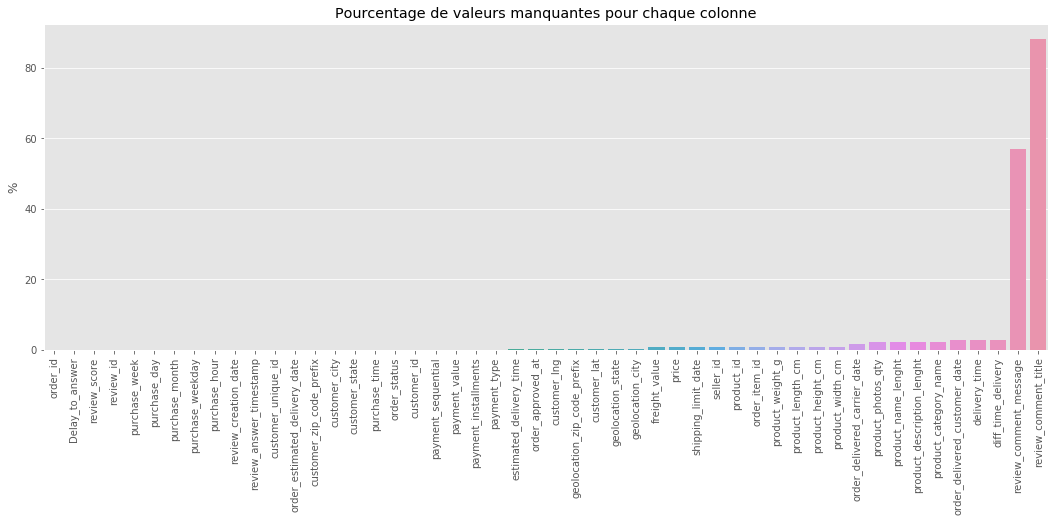

In [56]:
# Calcul des valeurs manquantes
null_prop = df.isna().sum(axis=0).sort_values()/len(df)*100

# Affiche la proportion de données manquants par colonne
fig = plt.figure(figsize=(18, 6))
sns.barplot(x=null_prop.index, y=null_prop.values)
plt.ylabel("%")
plt.title("Pourcentage de valeurs manquantes pour chaque colonne")
plt.style.use('ggplot')
plt.xticks(rotation=90)
plt.show()

#### Suppression des colonnes dont les données sont trop fortement manquantes

In [57]:
# Suppression des données dont les proportions renseignés sont <90%
cond = null_prop < 10
cond = cond[cond]
df = df.loc[:, cond.index]

#### Remplacement des valeurs manquantes numériques

In [58]:
# Liste des colonnes numériques
num_columns = list(df.select_dtypes(include='float64').columns)
# Les valeurs manquantes pour chaque colonnes numérique
# sont remplacés par les moyennes des colonnes
df[num_columns] = SimpleImputer(strategy='mean').fit_transform(df[num_columns])

#### Remplacement des valeurs manquantes catégorielles

In [59]:
# Liste des colonnes catégorielles
cat_columns = list(df.select_dtypes(include='object').columns)
# Les valeurs manquantes pour les colonnes catégorielles
# sont remplacés par la valeur la plus fréquente
df[cat_columns] = SimpleImputer(strategy='most_frequent')\
                    .fit_transform(df[cat_columns])

### 2.2 Analyse multivariée

In [60]:
# Affichage des 5 premières lignes
df.head()

,order_id,Delay_to_answer,review_score,review_id,purchase_week,purchase_day,purchase_month,purchase_weekday,purchase_hour,review_creation_date,...,product_height_cm,product_width_cm,order_delivered_carrier_date,product_photos_qty,product_name_lenght,product_description_lenght,product_category_name,order_delivered_customer_date,delivery_time,diff_time_delivery
0,e481f51cbdc54678b7cc49136f2d6af7,1.155417,4,a54f0611adc9ed256b57ede6b6eb5114,0,2,10,0,10,2017-10-11 00:00:00,...,8.0,13.0,2017-10-04 19:55:00,4.0,40.0,268.0,housewares,2017-10-10 21:25:13,8.429144,-7.107488
1,e481f51cbdc54678b7cc49136f2d6af7,1.155417,4,a54f0611adc9ed256b57ede6b6eb5114,0,2,10,0,10,2017-10-11 00:00:00,...,8.0,13.0,2017-10-04 19:55:00,4.0,40.0,268.0,housewares,2017-10-10 21:25:13,8.429144,-7.107488
2,e481f51cbdc54678b7cc49136f2d6af7,1.155417,4,a54f0611adc9ed256b57ede6b6eb5114,0,2,10,0,10,2017-10-11 00:00:00,...,8.0,13.0,2017-10-04 19:55:00,4.0,40.0,268.0,housewares,2017-10-10 21:25:13,8.429144,-7.107488
3,53cdb2fc8bc7dce0b6741e2150273451,0.776273,4,8d5266042046a06655c8db133d120ba5,0,24,7,1,20,2018-08-08 00:00:00,...,13.0,19.0,2018-07-26 14:31:00,1.0,29.0,178.0,perfumery,2018-08-07 15:27:45,12.502292,-5.355729
4,47770eb9100c2d0c44946d9cf07ec65d,4.797199,5,e73b67b67587f7644d5bd1a52deb1b01,0,8,8,2,8,2018-08-18 00:00:00,...,19.0,21.0,2018-08-08 13:50:00,1.0,46.0,232.0,auto,2018-08-17 18:06:29,9.382708,-17.245498


#### 2.2.1 Montant moyen et nombre de transactions

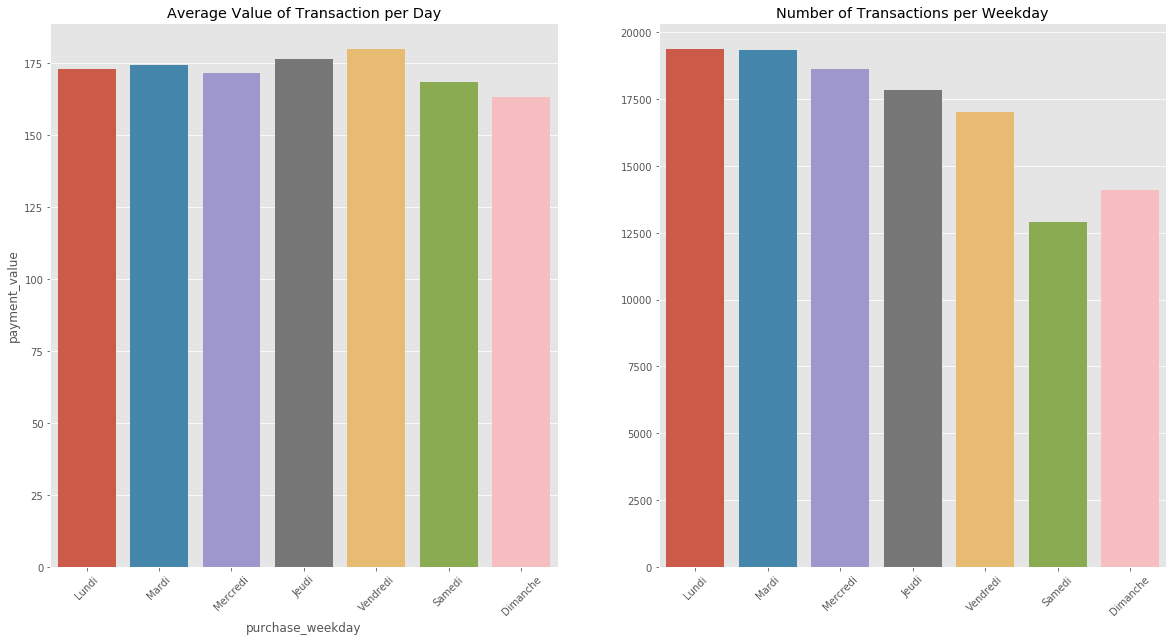

In [61]:
# Les données sont groupés par la variable 'purchase_weekday' et moyennés
payment_value_weekday = df.groupby("purchase_weekday")["payment_value"] \
                .mean().sort_values(ascending=False).reset_index()
order_weekday = df["purchase_weekday"].value_counts().sort_index()

# Jours de la semaine
WEEK = ["Lundi", "Mardi", "Mercredi",
        "Jeudi", "Vendredi", "Samedi", "Dimanche"]

fig = plt.figure(1, figsize=(20, 10))

# Bar plot du montant moyen dépensé pour chaque jour de la semaine
plt.subplot(121)
sns.barplot(data=payment_value_weekday, x="purchase_weekday",
            y="payment_value")
plt.title("Average Value of Transaction per Day")
plt.xticks(np.arange(7), WEEK, rotation=45)

# Bar plot du nombre de transactions pour chaque jour de la semaine
plt.subplot(122)
sns.barplot(x=order_weekday.index, y=order_weekday.values)
plt.xticks(np.arange(7), WEEK, rotation=45)
plt.title("Number of Transactions per Weekday")

plt.show()

- Le week-end il y'a  moins d'achats effectués que la semaine

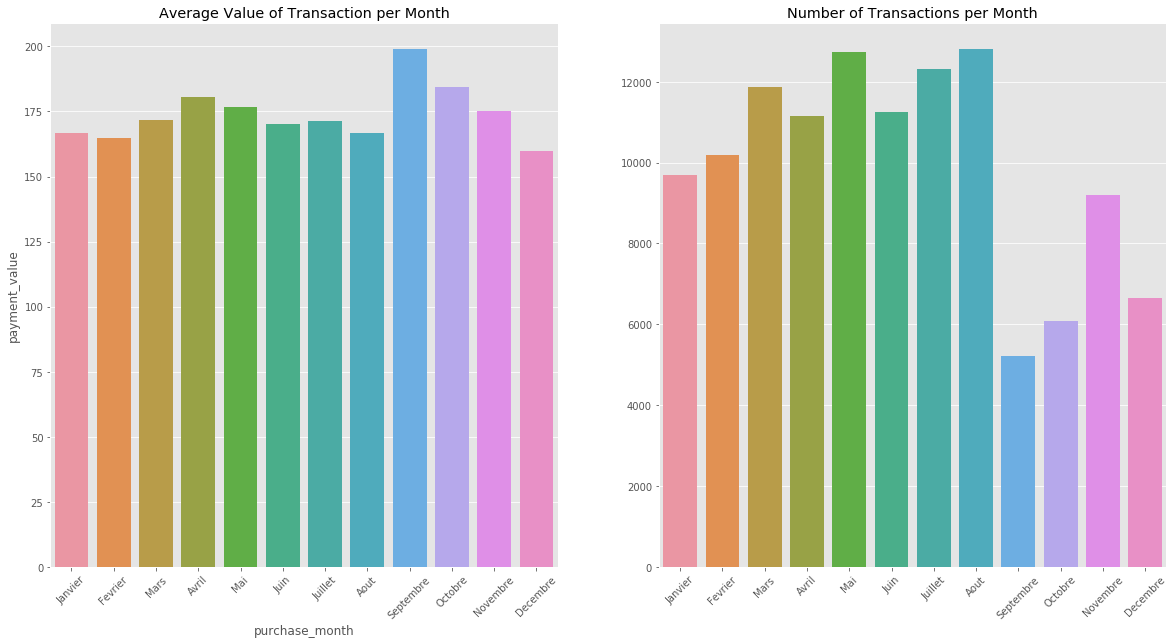

In [62]:
# Mois de l'année
MONTHS = ["Janvier", "Fevrier", "Mars", "Avril",
          "Mai", "Juin", "Juillet", "Aout",
          "Septembre", "Octobre", "Novembre", "Decembre"]

payment_value_month = df.groupby("purchase_month")["payment_value"] \
                    .mean().sort_values(ascending=False).reset_index()
order_month = df["purchase_month"].value_counts().sort_index()

fig = plt.figure(1, figsize=(20, 10))

# Bar plot de montant moyen dépensé pour chaque mois de l'année
plt.subplot(121)
sns.barplot(data=payment_value_month, x="purchase_month",
            y="payment_value")
plt.title("Average Value of Transaction per Month")
plt.xticks(np.arange(12), MONTHS, rotation=45)

# Bar plot du nombre de transactions pour chaque mois de l'année
plt.subplot(122)
sns.barplot(x=order_month.index, y=order_month.values)
plt.xticks(np.arange(12), MONTHS, rotation=45)
plt.title("Number of Transactions per Month")

plt.show()

- Septembre et Octobre sont des périodes creuses

- A partir de Novembre, les achats de fin d'année reviennent avec les fêtes

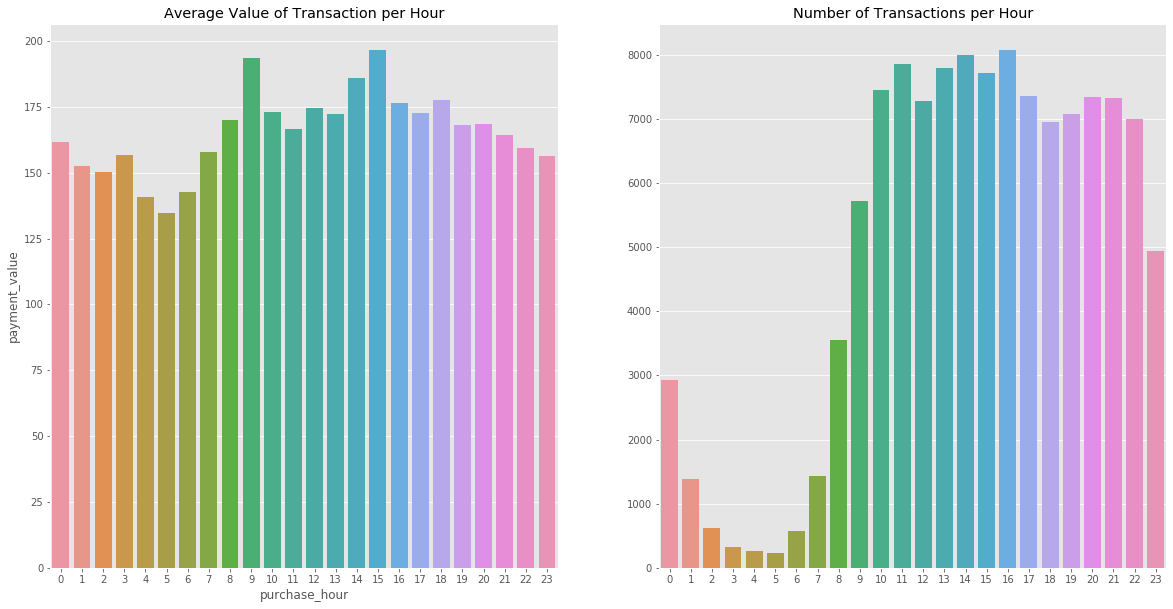

In [63]:
payment_value_hours = df.groupby("purchase_hour")["payment_value"] \
                    .mean().sort_values(ascending=False).reset_index()

order_hours = df["purchase_hour"].value_counts().sort_index()

fig = plt.figure(1, figsize=(20, 10))

# Bar plot du montant moyen dépensé pour chaque heure de la journée
plt.subplot(121)
sns.barplot(data=payment_value_hours, x="purchase_hour",
            y="payment_value")
plt.title("Average Value of Transaction per Hour")

# Bar plot du nombre de transactions pour chaque heure de la journée
plt.subplot(122)
sns.barplot(x=order_hours.index, y=order_hours.values)
plt.title("Number of Transactions per Hour")

plt.show()

- Il y a évidemment moins de payements la nuit que le jour

#### 2.2.2 Evaluation des produits

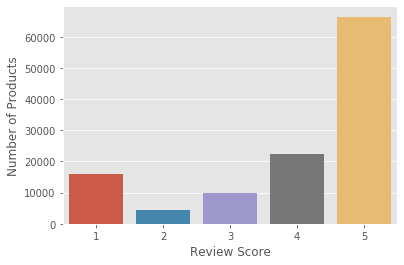

In [64]:
# Nombre de produits pour chaque note
review_score = df["review_score"].value_counts()
# bar plot du nombre de produits pour chaque note de 1 à 5
sns.barplot(review_score.index, review_score.values)
plt.ylabel("Number of Products")
plt.xlabel("Review Score")
plt.show()

- La majorité des produits sont notés 5 sur une échelle de 5

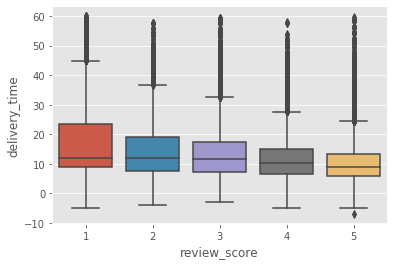

In [65]:
# Boxplot du temps de livraison pour chaque note
sns.boxplot(x="review_score", y="delivery_time",
            data=df[df["delivery_time"] < 60])
plt.show()

- Plus le temps d'attente est faible et plus l'évaluation du produit est bonne

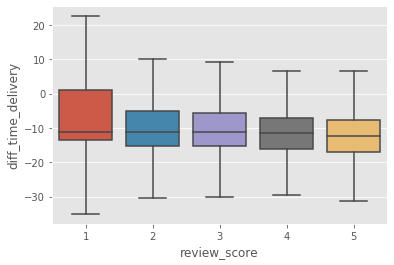

In [66]:
# Boxplot de la différence entre le temps de livraison réelle
# et estimé, pour chaque note du review score
sns.boxplot(x="review_score", y="diff_time_delivery",
            data=df[df["delivery_time"] < 60], showfliers=False)
plt.show()

- Plus un produit est livré plus tôt que son temps de livraison estimé et plus sa note est élevé

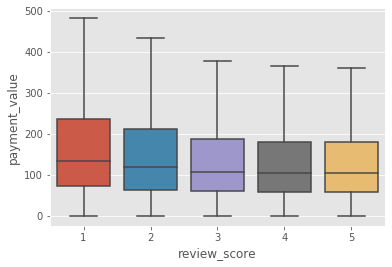

In [67]:
# Boxplot du payement effectué pour chaque note
sns.boxplot(x="review_score", y="payment_value", data=df, showfliers=False)
plt.show()

- Plus le prix de la transaction est faible et plus son évaluation est bonne

#### 2.2.3 Catégories des produits

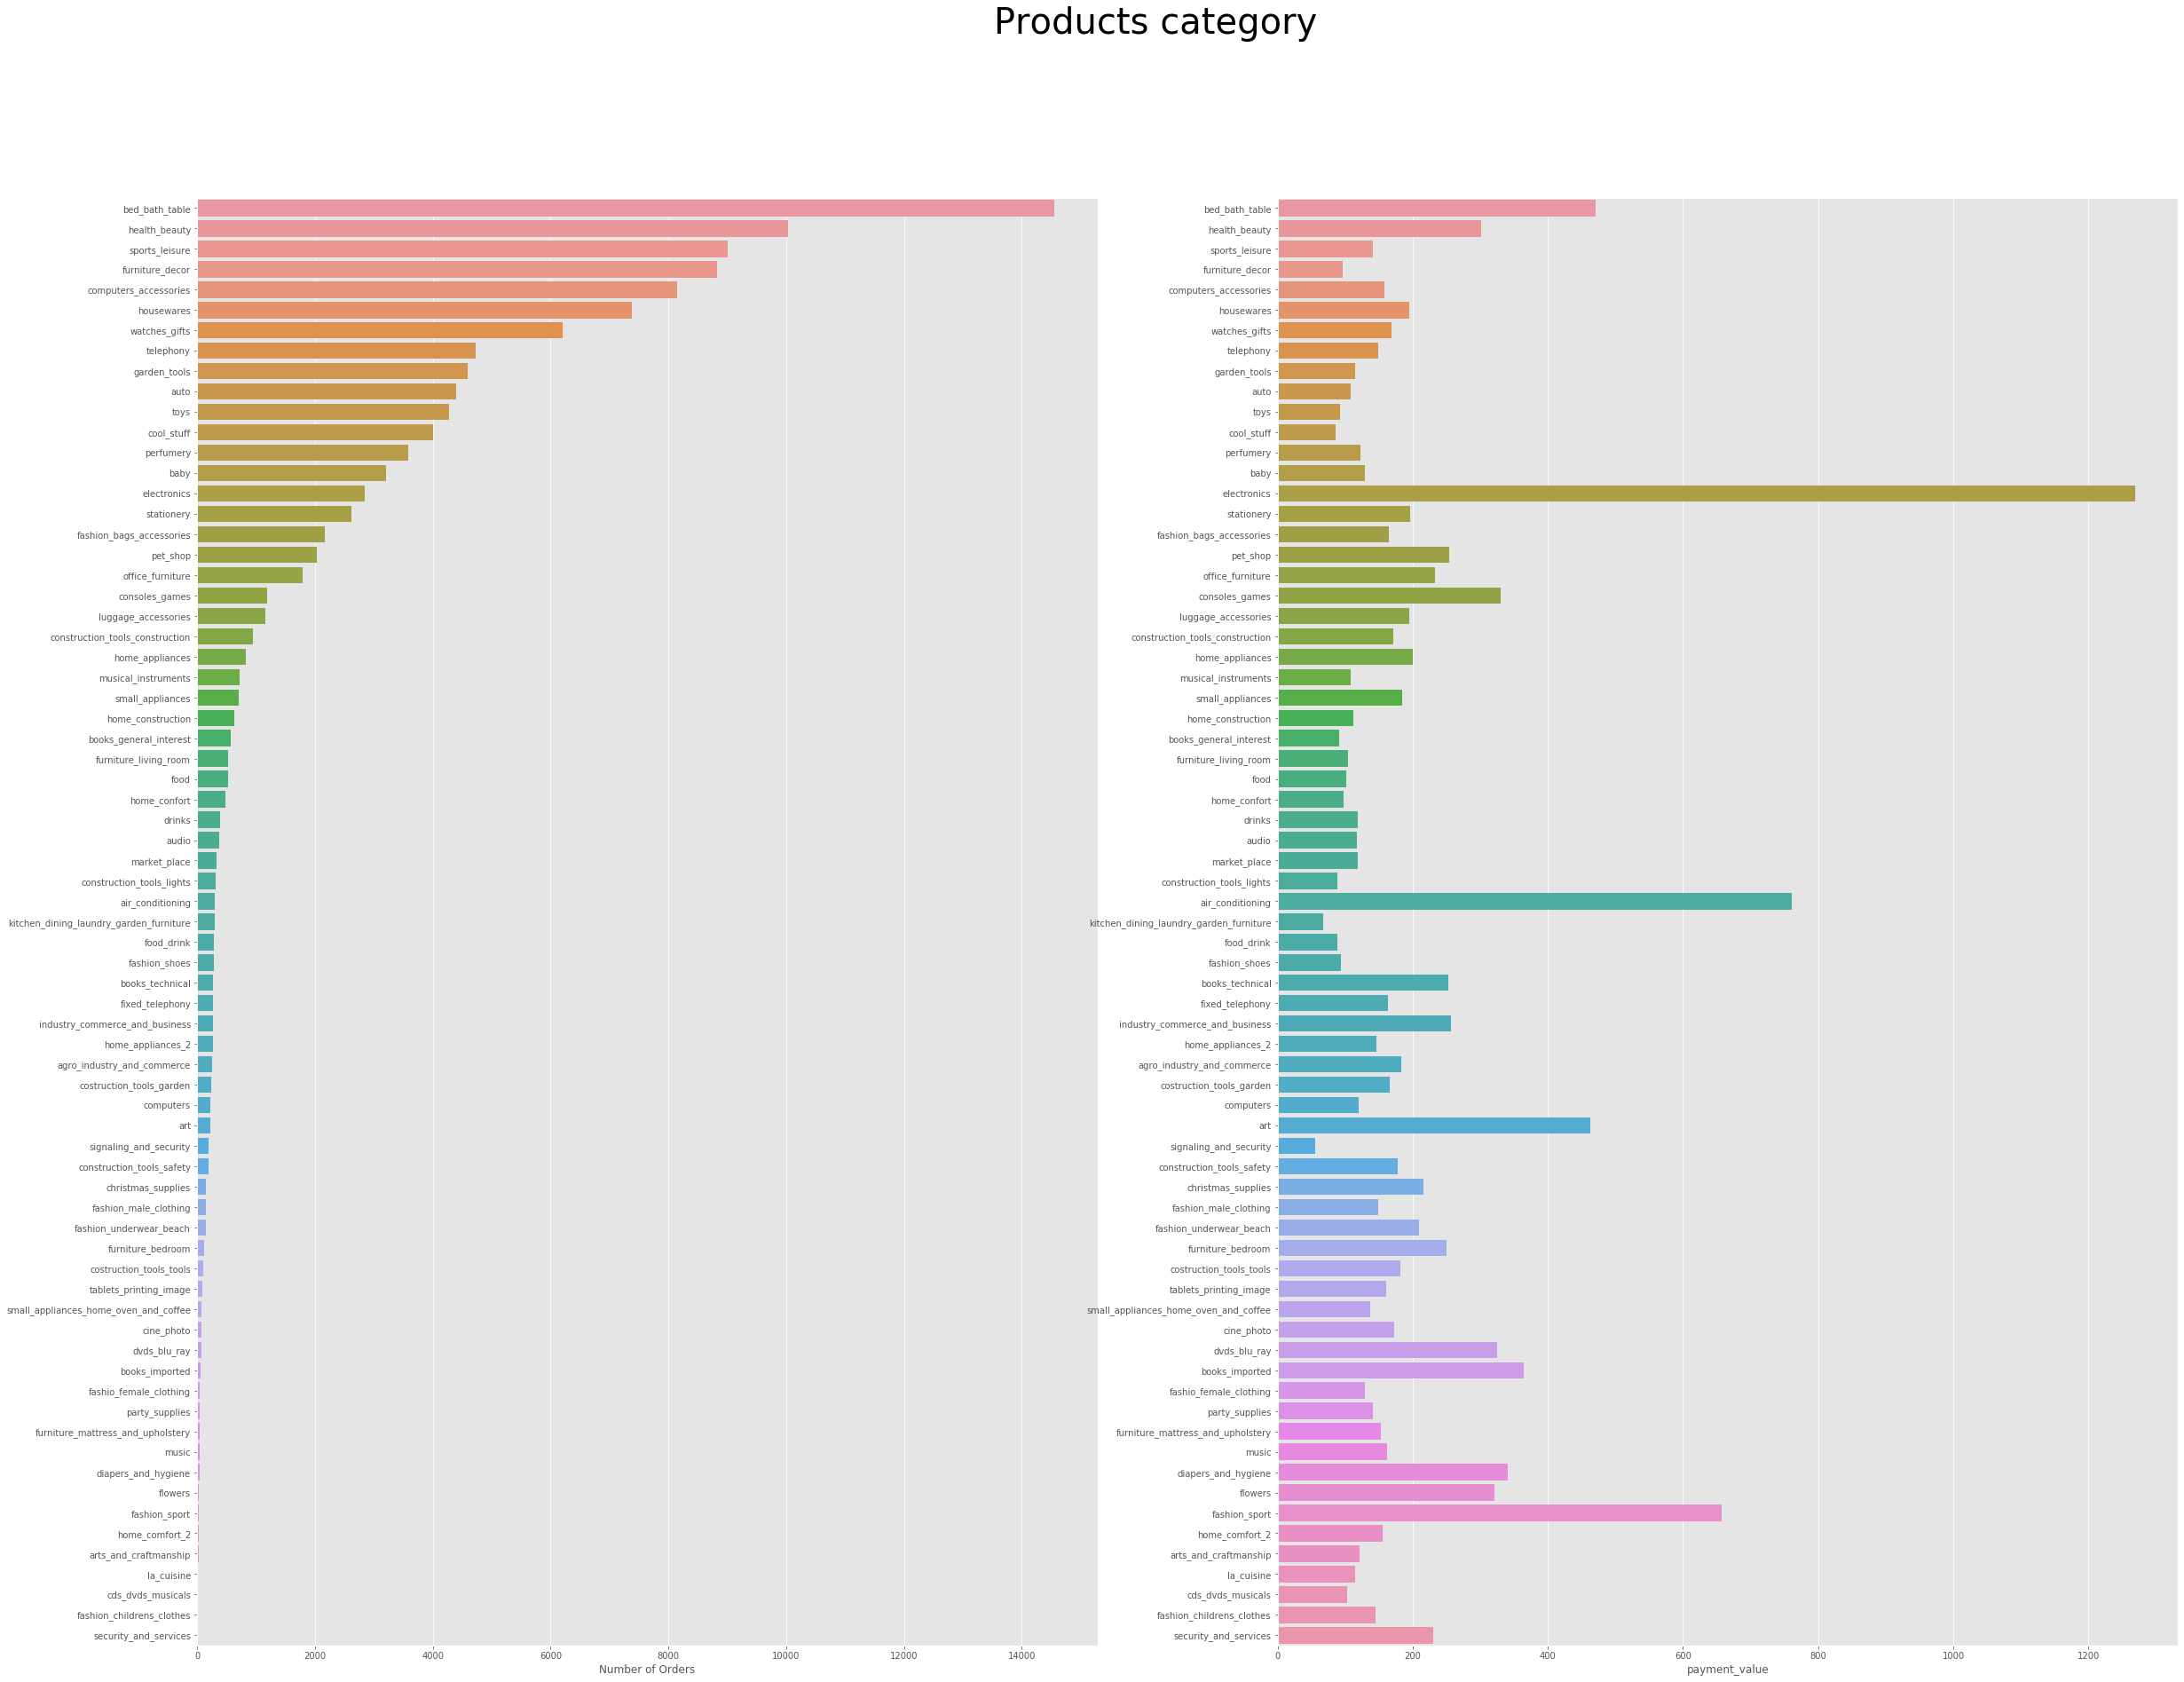

In [68]:
# Nombre de produits par catégorie de produits
products_count = df['product_category_name'].value_counts()

# Payement moyen pour chaque catégorie de produits
products_value = df.groupby("product_category_name")["payment_value"].mean()

# Liste des catégories
y = list(products_count.index)

fig = plt.figure(1, figsize=(40, 30))
# Nombre de produits achetés par catégorie
plt.subplot(121)
sns.barplot(products_count.values, y)
plt.xlabel("Number of Orders")

# Payement moyen par catégorie de produits
plt.subplot(122)
sns.barplot(products_value, y)
fig.suptitle("Products category", fontsize=40)
plt.show()

## 3. Segmentation RFM

Le principe de la segmentation RFM est mentionné au début du notebook

### 3.1 Calcul des variables R, F et M

On s'intèresse à une période d'une année entière, soit 365 jours

In [69]:
# On s'intèresse à une période d'une année entière, soit 365 jours
period = 365
# Séléction des variables permettant le calcul RFM
data = df[["customer_id", "purchase_time", "payment_value"]]

Calcul des variables R, F et M

In [70]:
def calculateRFM(data, period, today):
    """
    Calcul des valeurs R, F et M.

    Paramètres:
    data(pd.DataFrame): doit contenir les colonnes 'payment_value',
    'purchase_time' et 'customer_id'
    period(int): Nombre de jours
    today(dt.datetime): date de fin de période

    Return:
    rfm(pd.DataFrame): retourne un pd.DataFrame avec les variables Recency,
    Frequency et Monetary
    """
    # Nombre de jours passés entre aujourd'hui
    # et la dernière commande de chaque utilisateur
    data["DaysSinceOrder"] = data["purchase_time"]\
                             .map(lambda d: (today - d).days)

    aggr = {
            'DaysSinceOrder': lambda x: x.min(),
            # Nombre de jours depuis la dernière commande (Recency)
            'purchase_time': lambda x:
            len([d for d in x if d >= today - timedelta(days=period)]),
            # le nombre total de transactions pour la période passé (Frequency)
    }

    rfm = data.groupby('customer_id').agg(aggr).reset_index()
    rfm.rename(columns={'DaysSinceOrder': 'Recency',
                        'purchase_time': 'Frequency'},
               inplace=True)

    # Montant total de toutes les transactions sur la période définie
    rfm['Monetary'] = rfm['customer_id'].apply(lambda x:
                      data[(data['customer_id'] == x) &
                           (data['purchase_time'] >= today -
                           timedelta(days=period))]['payment_value'].sum()
                      )
    # Affichage des 5 premières lignes
    rfm.head()

    return rfm

In [71]:
# Jour actuel : date de la dernière commande
today = data["purchase_time"].max()

In [72]:
# Calcul RFM, entre la date de la dernière commande
# et il y a 365 jours
rfm_1 = calculateRFM(data, period, today)

C:\Users\maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [73]:
# Affichage des 5 premières lignes
rfm_1.head()

,customer_id,Recency,Frequency,Monetary
0,00012a2ce6f8dcda20d059ce98491703,337,1,114.74
1,000161a058600d5901f007fab4c27140,458,0,0.00
2,0001fd6190edaaf884bcaf3d49edf079,596,0,0.00
3,0002414f95344307404f0ace7a26f1d5,427,0,0.00
4,000379cdec625522490c315e70c7a9fb,198,1,107.01


##### Interprétation : 

- customer_id 00012a2ce6f8dcda20d059ce98491703 a fait son dernier achat il y a 337 jours, a commandé 1 fois sur une période d'un an, pour un montant total de 114.74 R$
    
    
- customer_id 0002414f95344307404f0ace7a26f1d a fait son dernier achat il y a 427 jours, et n'a pas commandé cette année, le montant total de toutes ses commandes est donc égale à 0 R$

#### Description des données

In [74]:
# Description arithmétique des données
rfm_1.describe()

,Recency,Frequency,Monetary
count,99441.000000,99441.000000,99441.000000
mean,289.900192,0.831116,143.819952
std,153.667316,0.792258,442.671201
min,0.000000,0.000000,0.000000
25%,166.000000,0.000000,0.000000
50%,271.000000,1.000000,67.500000
75%,400.000000,1.000000,151.740000
max,772.000000,24.000000,44048.000000


In [75]:
print("Le nombre de clients ayant commandé plus d'une fois est de : {:.2f} %"
      .format(100*(len(data) - rfm_1["customer_id"].nunique())/len(data)))

Le nombre de clients ayant commandé plus d'une fois est de : 16.54 %


### 3.2 Analyse graphique des variables R, F et M

#### 3.2.1 Distribution en histogramme

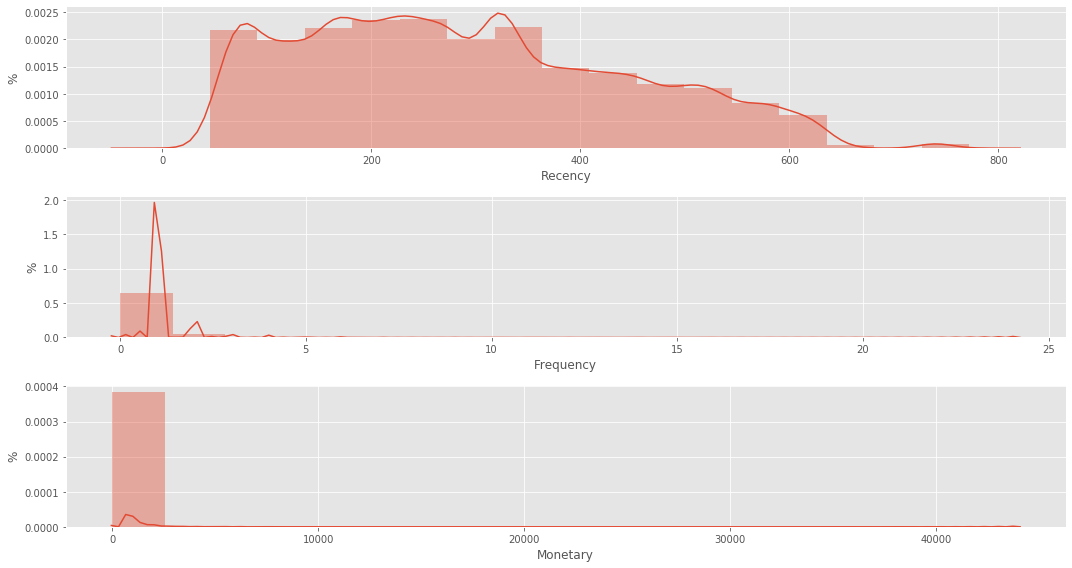

In [76]:
fig = plt.figure(1, figsize=(15, 8))

# Histogramme de la variable Recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_1.Recency, label='Recency',
             bins=int(1 + np.log2(len(rfm_1))))
plt.ylabel("%")

# Histogramme de la variable Frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_1.Frequency, label='Frequency',
             bins=int(1 + np.log2(len(rfm_1))))
plt.ylabel("%")

# Histogramme de la variable Monetary
plt.subplot(3, 1, 3)
sns.distplot(rfm_1.Monetary, label='Monetary',
             bins=int(1 + np.log2(len(rfm_1))))
plt.ylabel("%")
plt.style.use('ggplot')
plt.tight_layout()
plt.show()

#### 3.2.2 Boites à moustaches

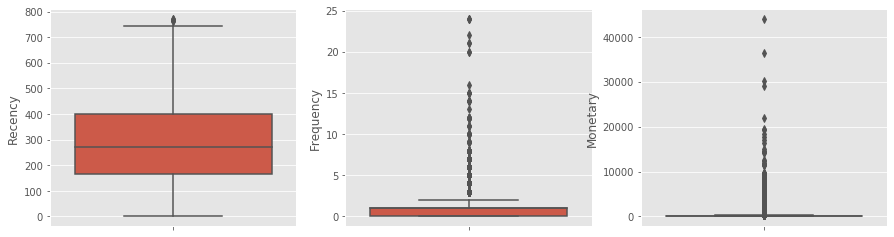

In [77]:
fig = plt.figure(1, figsize=(15, 4))

# Boxplot de la variable Recency
plt.subplot(131)
sns.boxplot(rfm_1["Recency"], orient="vertical")

# Boxplot de la variable Frequency
plt.subplot(132)
sns.boxplot(rfm_1["Frequency"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(133)
sns.boxplot(rfm_1["Monetary"], orient="vertical")
plt.show()

In [78]:
print("L'essentiel des montants se situe autour de la médiane qui est de {}. \n"
      "Pour la fréquence la très grande majorité des clients ont commandé soit 0 ou 1 fois."
      .format(rfm_1["Monetary"].median(), rfm_1["Frequency"].median()))

L'essentiel des montants se situe autour de la médiane qui est de 67.5. 
Pour la fréquence la très grande majorité des clients ont commandé soit 0 ou 1 fois.


### 3.3 Méthode 1 : RFM Score

La méthode 1 consiste à quantiliser chaque segment RFM de manière à obtenir un score entre 1 et 5 pour chaque variable R, F et M.

En fonction de chaque score obtenu, le client sera attribué dans une catégorie.

#### Calcul des quantiles

In [79]:
def r_score(x, quintiles):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus la 'Recency' est faible, plus la note
    est élevé
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1


def fm_score(x, quintiles, c):
    """
    Attribut une note entre 1 et 5 suivant l'emplacement de x par
    rapport aux quintiles. Plus x est grand, plus la note est grande
    x(float): valeur
    quintiles(dict): voir fonction calculQuantile
    """

    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5


def calculQuantile(rfm):
    """
    Calcul des quantiles pour chaque variable Recency, Frequency et Monetary
    puis attribut un score (fm_score et r_score) suivant la valeur
    des variables de chaque individu
    rfm(pd.DataFrame): présente les colonnes 'Recency', 'Frequency' et Monetary
    """
    quintiles = rfm[['Recency',
                     'Frequency',
                     'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

    rfm['R'] = rfm['Recency'].apply(lambda x:
                                    r_score(x, quintiles))
    rfm['F'] = rfm['Frequency'].apply(lambda x:
                                      fm_score(x, quintiles, 'Frequency'))
    rfm['M'] = rfm['Monetary'].apply(lambda x:
                                     fm_score(x, quintiles, 'Monetary'))
    return rfm

In [80]:
# Calcul des quantiles
rfmTable_1 = calculQuantile(rfm_1)

#### Calcul des segments et des scores


Chaque client est caractérisé en fonction de la note pour chaque variable R, F M qui le caractérise

9 segments sont définis : 
 - Champions : achats récents, achète souvent et dépense beaucoup
 - Loyal Customers : achètent régulièrement, sensibles aux promotions
 - Potential Loyalist : nouveaux clients avec fréquence d'achat moyenne
 - Recent Customers : achats récents, mais peu fréquents
 - Promising : nouveaux acheteurs, mais peu dépensiers
 - Need Attention : dépenses moyennes, moyennement fréquemment, achat moyennement récent
 - About to Sleep : client qui tendent à disparaitre
 - Can't Lose Them : achètaient régulièrement, besoin de les faire revenir
 - At Risk : dépensaient beaucoup, achetaient souvent mais il y a lomgtemps
 - Lost : peu dépensiers, peu fréquements, a acheté il y a un moment
 - Others : pas catégorisable

In [81]:
categories_1 = ["Champions",
                "Loyal Customers",
                "Potential Loyalist",
                "Recent Customers",
                "Promising",
                "Need Attention",
                "About To Sleep",
                "Can't Lose Them",
                "At Risk",
                "Lost",
                "Others"]

In [82]:
def calculSegment(rfm):
    """
    Retourne le segment associé au client en fonction de son score pour les
    variables R, F et M

    Paramètres:
    rfm(pd.DataFrame): doit contenir les colonnes R, F et M

    Return:
    str: Nom du segment
    """

    if 4 <= rfm["R"] <= 5 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Champions"

    elif 3 <= rfm["R"] <= 5 and 3 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "Loyal Customers"

    elif 3 <= rfm["R"] <= 5 and 1 <= rfm["F"] <= 3 and 1 <= rfm["M"] <= 3:
        return "Potential Loyalist"

    elif rfm["R"] >= 4 and rfm["F"] <= 2:
        return "Recent Customers"

    elif 3 <= rfm["R"] <= 4 and rfm["F"] <= 1 and rfm["M"] <= 1:
        return "Promising"

    elif 2 <= rfm["R"] <= 3 and 2 <= rfm["F"] <= 3 and 2 <= rfm["M"] <= 3:
        return "Need Attention"

    elif 2 <= rfm["R"] <= 3 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "About To Sleep"

    elif rfm["R"] <= 1 and 4 <= rfm["F"] <= 5 and 4 <= rfm["M"] <= 5:
        return "Can't Lose Them"

    elif rfm["R"] <= 2 and 2 <= rfm["F"] <= 5 and 2 <= rfm["M"] <= 5:
        return "At Risk"

    elif rfm["R"] <= 2 and rfm["F"] <= 2 and rfm["M"] <= 2:
        return "Lost"

    else:
        return "Others"

#### Attribution des catégories

In [83]:
# RFM Score
rfmTable_1["RFM Score"] = rfmTable_1.apply(calculSegment, axis=1)

#### Apperçu des résultats

In [84]:
# Affiche les 5 premières lignes
rfmTable_1.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,00012a2ce6f8dcda20d059ce98491703,337,1,114.74,2,2,4,At Risk
1,000161a058600d5901f007fab4c27140,458,0,0.00,1,1,1,Lost
2,0001fd6190edaaf884bcaf3d49edf079,596,0,0.00,1,1,1,Lost
3,0002414f95344307404f0ace7a26f1d5,427,0,0.00,2,1,1,About To Sleep
4,000379cdec625522490c315e70c7a9fb,198,1,107.01,4,2,4,Recent Customers


#### Résumé des résultats de la segmentation

In [85]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']
# Regroupement des données
qtd_preco = rfmTable_1.groupby(['RFM Score'])
# Aggrégation des données par différentes fonctions
summery_table = qtd_preco['Recency', 'Frequency', 'Monetary'].agg(func)
# Affichage de la table de résumé
summery_table

Recency                                         Frequency  \
                     count  min        mean median  max        std     count   
RFM Score                                                                      
About To Sleep       10345  365  399.984727    399  436  20.915797     10345   
At Risk               5533  321  337.722031    334  364  13.111048      5533   
Champions             4392   49  143.875911    150  229  51.396816      4392   
Lost                 19751  437  526.540681    518  772  62.304861     19751   
Loyal Customers       3087   50  248.659216    260  320  58.466384      3087   
Need Attention        4022  321  337.091745    334  364  12.997897      4022   
Others                9094  230  273.889598    273  320  27.141096      9094   
Potential Loyalist   24543    0  184.849611    188  320  77.702003     24543   
Recent Customers     18674    0  141.318893    145  229  52.237127     18674   

                                                      Monetary         \
                   min      mean median max       std    count    min   
RFM Score                                                               
About To Sleep       0  0.000000      0   0  0.000000    10345   0.00   
At Risk              1  1.384963      1  24  0.932853     5533  16.05   
Champions            2  2.515483      2  24  1.280065     4392  94.88   
Lost                 0  0.000000      0   0  0.000000    19751   0.00   
Loyal Customers      2  2.462909      2  24  1.351112     3087   9.59   
Need Attention       1  1.000000      1   1  0.000000     4022  11.63   
Others               1  1.000000      1   1  0.000000     9094  94.74   
Potential Loyalist   1  1.000000      1   1  0.000000    24543  10.89   
Recent Customers     1  1.000000      1   1  0.000000    18674  94.74   

                                                                
                          mean   median       max          std  
RFM Score                                                       
About To Sleep        0.000000    0.000      0.00     0.000000  
At Risk             329.174236  180.710  36489.24   774.687882  
Champions           671.067842  359.875  30186.00  1292.939186  
Lost                  0.000000    0.000      0.00     0.000000  
Loyal Customers     459.852676  236.000  44048.00  1186.225809  
Need Attention       57.263138   57.580     94.71    19.359481  
Others              221.117313  161.335   3826.80   207.206102  
Potential Loyalist   57.414624   57.100     94.72    20.079772  
Recent Customers    239.000930  163.890   6922.21   264.129815

#### Radar Chart des différentes catégories

In [86]:
def radar_plot(rfmTable, label_score, colors) :
    
    """
    Pour chaque cluster/segments, trace un radar chart représentant
    la moyenne des individus pour les variables Recency, Monetary
    et Frequency, ainsi que le nombre d'individus dans le cluster/segment
    en question.
    rfmTable(pd.DataFrame): Table de résultats, doit contenir
    les 3 variables Recency, Frequency et Monetary
    ainsi que la colonne avec les segments de chaque individu
    label_score: nom de la segmentation
    colors(list): code couleur
    """
    
    # Aggrégation par moyenne des valeurs par segment
    df_plot = rfmTable.groupby([label_score])['Recency',
                                            'Frequency',
                                            'Monetary'].agg("mean")
    # Ajout du nombre de clients par segment
    df_plot["Count"] = rfmTable.groupby([label_score])\
                       .agg("count")["Recency"].values
    
    # Transformation MinMax -> [0, 1]
    df_plot_std = pd.DataFrame(MinMaxScaler().fit_transform(df_plot),
                           columns=list(df_plot.columns),
                           index=df_plot.index)

    # Noms des variables
    categories = list(df_plot.columns)
    # Nombre de variables
    N = len(categories)

    # Quel sera l'angle de chaque axe ?
    # On divise un tour complet par le nombre de variables
    angles = [n / float(N) * 2 * pi for n in range(N)]


    fig = plt.figure(1, figsize=(20, 12))

    # Trace un radar chart pour chaque segment
    for i, segment in enumerate(rfmTable[label_score].unique()):

        ax = fig.add_subplot(2, 5, i + 1, polar=True)

        ax.set_theta_offset(2 * pi / 3)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels labels yet
        plt.yticks(color="grey", size=2)
        values = df_plot_std.loc[segment].values
        ax.plot(angles, values, colors[segment], 'o-', linewidth=1)
        ax.fill(angles, values, colors[segment], alpha=0.25)
        ax.set_xticks(angles)
        ax.set_xticklabels(categories)
        ax.set_title(segment, size=15, color=colors[segment])
        ax.grid(True)
        plt.ylim(-1.5, 1.5)

    plt.show()

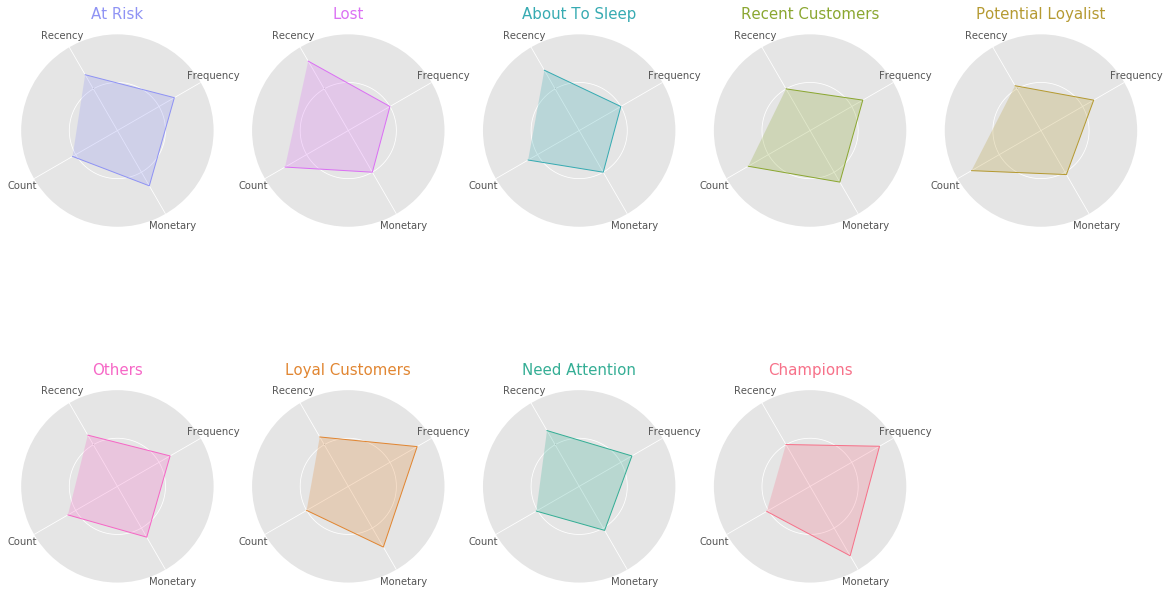

In [87]:
# Liste des couleurs pour chaque segment
palette_1 = sns.color_palette("husl", len(categories_1))
colors_1 = {label: color for label, color in zip(categories_1,
                                                 palette_1.as_hex())}
radar_plot(rfmTable_1, 'RFM Score', colors_1)

c.f la partie Calcul des segments et des scores pour lier le radar chart au descriptif de chaque segment

#### Visualisation graphique 3d des différents clients associés à leur catégorie

In [88]:
def projection_3d_segments(rfmTable, label_score, colors) :
    """
    Graphique montrant les différents clients associés à leur segment/cluster respectif
    rfmTable(pd.DataFrame): Table de résultats
    label_score(str): nom de la segmentation
    colors(list): liste de couleurs

    """
    fig = plt.figure(1, figsize=(18, 8))

    dx = fig.add_subplot(111, projection='3d')
    # Pour chaque segment, scatter plot des individus avec code couleur
    for i, segment in enumerate(rfmTable[label_score].unique()):
        dx.scatter(rfmTable[rfmTable[label_score] == segment].Recency,
                   rfmTable[rfmTable[label_score] == segment].Frequency,
                   rfmTable[rfmTable[label_score] == segment].Monetary,
                   label=segment,
                   s=50,
                   c=colors[segment])
    # Titre des axes et titre graphique
    dx.set_xlabel("Recency")
    dx.set_ylabel("Frequency")
    dx.set_zlabel("Monetary")
    plt.title("Représentation 3D des différents individus dans chaque segment")

    plt.legend()
    plt.show()

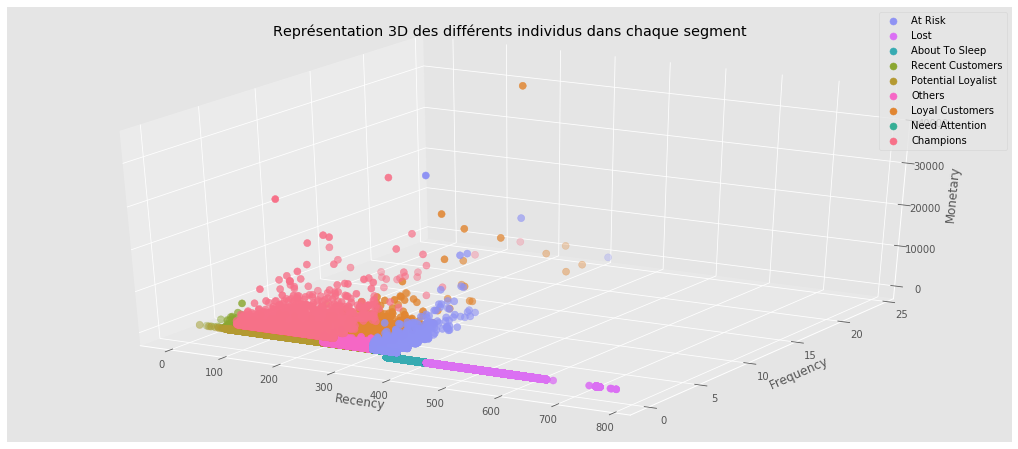

In [89]:
# Graphique 3D (x, y, z) = (Recency, Frequency, Monetary)
projection_3d_segments(rfmTable_1, 'RFM Score', colors_1)

On visualise graphiquement ici la nature très rectiligne de la segmentation

In [90]:
def projection_2d_segments(data, xlabel, ylabel, label_score, colors) :
    """
    2D scatter plot
    data(pd.DataFrame): contient les 3 colonnes xlabel, ylabel et label_score
    xlabel(str): nom colonne data pour l'axe des x
    ylabel(str): nom colonnne data pour l'axe des y
    label_score: nom méthodologie de la segmentation
    """
    # Pour chaque segment, scatter plot
    for i, segment in enumerate(rfmTable_1[label_score].unique()):
        plt.scatter(data[data[label_score] == segment][xlabel],
                    data[data[label_score] == segment][ylabel],
                    label=segment,
                    c=colors[segment]
                   )
    # Titre des axes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

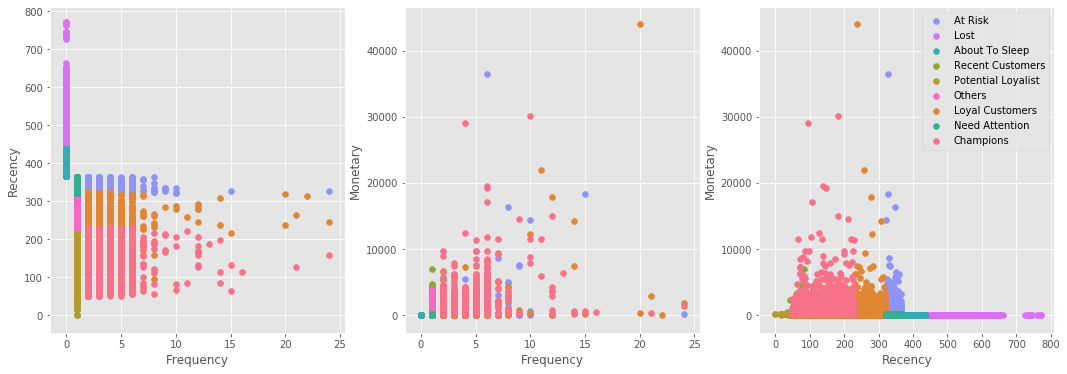

In [91]:
fig = plt.figure(1, figsize=(18, 6))

# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfmTable_1,
                       "Frequency",
                       "Recency",
                       "RFM Score",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfmTable_1,
                       "Frequency",
                       "Monetary",
                       "RFM Score",
                       colors=colors_1)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfmTable_1,
                       "Recency",
                       "Monetary",
                       "RFM Score",
                       colors=colors_1)

plt.legend()
plt.show()

### 3.4 Méthode 2 : Segmentation par clusterisation

#### Méthodologie :
   - 1. Normalisation des données
   - 2. Clusterisation des données par k-means
   - 3. Choisir le nombre de clusters
   - 4. Etiquetter les clusters

####  Méthodes pour définir le nombre de clusters

- Méthode visuelle :  Critère d'Elbow

- Méthode mathématique : Coefficient de Silhouette

- Expérimentation et interprétation


##### Critère d'Elbow :

- Afficher le nombre de clusters vs la somme des distances quadratiques de tous les points au centre de leurs clusters

- Identifier un "elbow" (coude) dans le graphique

- Elbow - un point représentant le nombre optimal de clusters

<img src="wcss.png">

##### Coefficient de silhouette

En partitionnement de données (clustering), le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique. 

Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec le points des autres groupes voisins (séparation). Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. Il varie de -1 (pire classification) à 1 (meilleur classification)


<img src="silhouette.png">

#### Normalisation des données 

In [92]:
# Encodeur par normalisation
encoder = StandardScaler()

# Normalisation des données
X_transformed_1 = encoder.fit_transform(
    rfm_1[["Recency", "Frequency", "Monetary"]])

# Convertis les données en DataFrame
rfm_std_1 = pd.DataFrame(X_transformed_1, index=rfm_1.index,
                         columns=["Recency", "Frequency", "Monetary"])

#### Clusterisation et détermination du nombre de clusters

Dans cette partie, nous allons déterminer quel est le nombre de clusters qui nous permet d'avoir les meilleurs résultats.

In [94]:
def wcss_clustering_rfm(rfm):
    """
    Cette fonction teste pour différents nombre de clusters,
    un clustering des données par la méthode k-means.
    La fonction affiche le score de silhouette pour chacun des clusters,
    ainsi que la répartition des données dans l'espace RFM
    et leurs codes couleurs associés en fonction de leur appartenance
    aux différents clusters déterminés.


    Parametres:
    rfm (pd.DataFrame): DataFrame avec 3 colonnes nommés :
    Recency, Frequency and Monetary

    Return :
    list: Liste des valeurs d'intertie pour différents nombre de clusters
    """

    # Liste des valeurs d'inertie
    wcss = []
    # Liste du nombre de clusters à tester
    range_n_clusters = [3, 4, 5, 6, 7, 8]
    palette = sns.color_palette("husl", max(range_n_clusters))
    colors_2 = palette.as_hex()
    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig = plt.figure(1, figsize=(18, 7))
        ax1 = fig.add_subplot(121)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example
        # all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(rfm) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, init='k-means++',
                           random_state=10)
        cluster_labels = clusterer.fit_predict(rfm)
        wcss.append(clusterer.inertia_)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation
        # of the formed clusters
        silhouette_avg = silhouette_score(rfm, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silh_values = silhouette_samples(rfm, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silh_values = sample_silh_values[cluster_labels == i]

            ith_cluster_silh_values.sort()

            size_cluster_i = ith_cluster_silh_values.shape[0]
            y_upper = y_lower + size_cluster_i

            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_cluster_silh_values,
                              facecolor=colors_2[i],
                              edgecolor=colors_2[i],
                              alpha=0.7)

            # Label the silhouette plots with
            # their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        dx = fig.add_subplot(122, projection='3d')

        rfm["clusters"] = cluster_labels
        for i in range(n_clusters):
            color = cm.nipy_spectral(float(i) / n_clusters)
            dx.scatter(rfm[rfm.clusters == i].Recency,
                       rfm[rfm.clusters == i].Frequency,
                       rfm[rfm.clusters == i].Monetary,
                       c=colors_2[i],
                       label='Cluster ' + str(i+1),
                       s=50)

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            dx.scatter(centers[:, 0],
                       centers[:, 1],
                       centers[:, 2],
                       marker='o',
                       c="white",
                       alpha=1,
                       s=200,
                       edgecolor='k')

            for i, c in enumerate(centers):
                dx.scatter(c[0],
                           c[1],
                           c[2],
                           marker='$%d$' % i,
                           alpha=1,
                           s=50,
                           edgecolor='k')
        # Titres des axes
        dx.set_xlabel("Recency")
        dx.set_ylabel("Frequency")
        dx.set_zlabel("Monetary")

        plt.suptitle(("Silhouette analysis for k-means clustering "
                      "on sample data with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

    return wcss  # Inertie

For n_clusters = 3 The average silhouette_score is : 0.6179019472581486


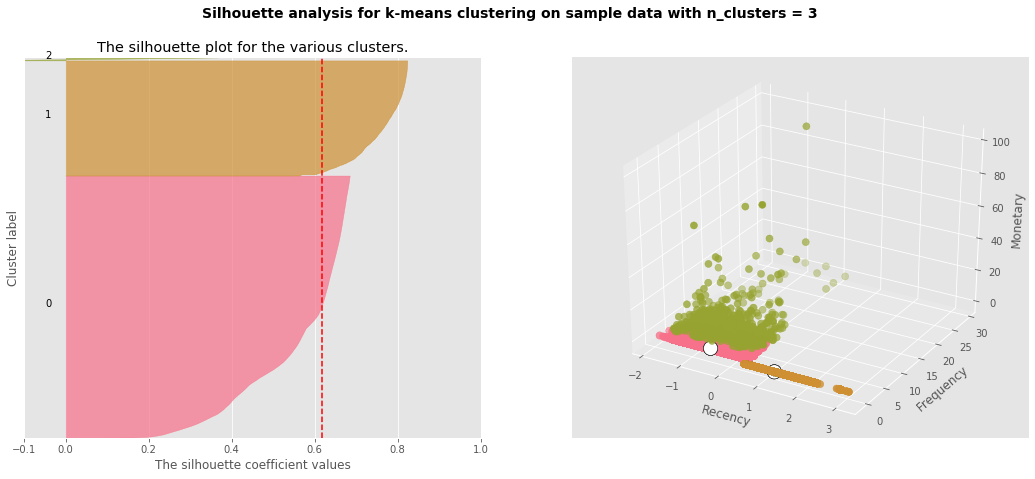

For n_clusters = 4 The average silhouette_score is : 0.657549449791521


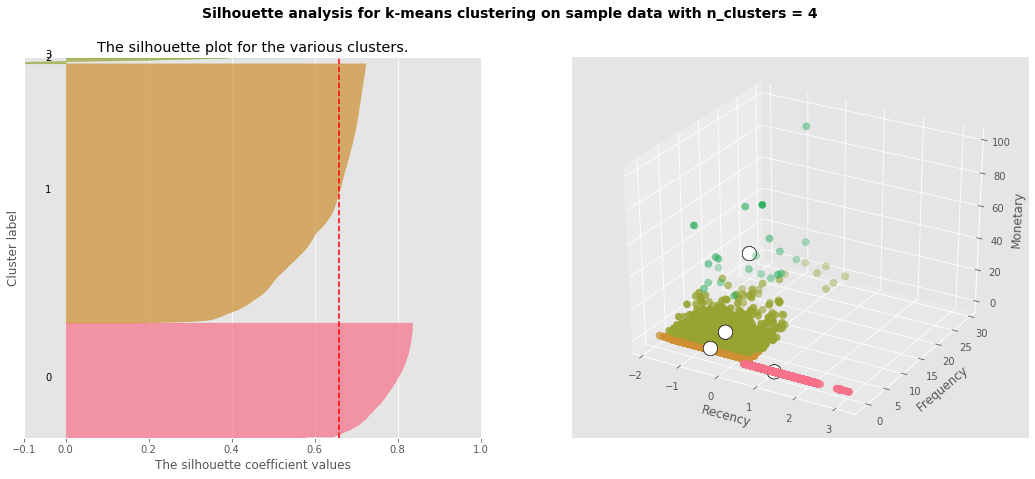

For n_clusters = 5 The average silhouette_score is : 0.622007494675506


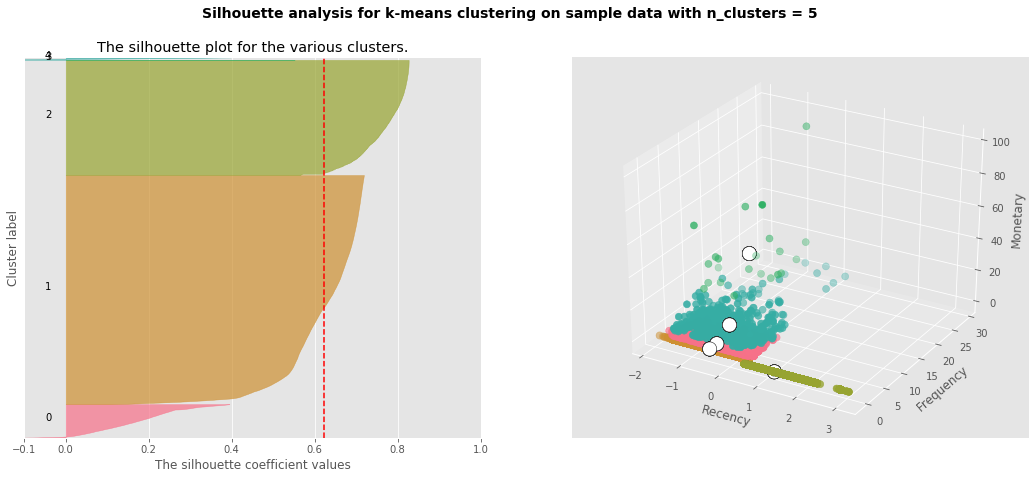

For n_clusters = 6 The average silhouette_score is : 0.5562084696129383


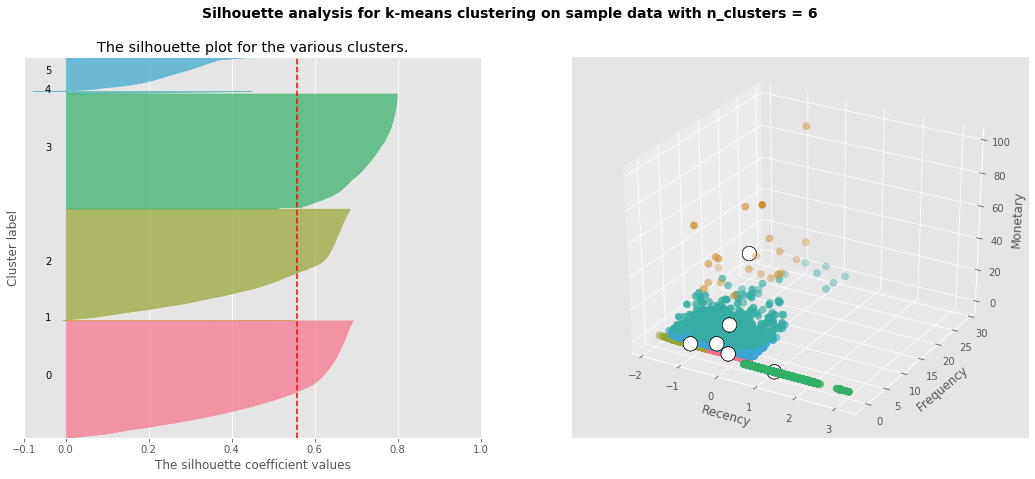

For n_clusters = 7 The average silhouette_score is : 0.7675659367651682


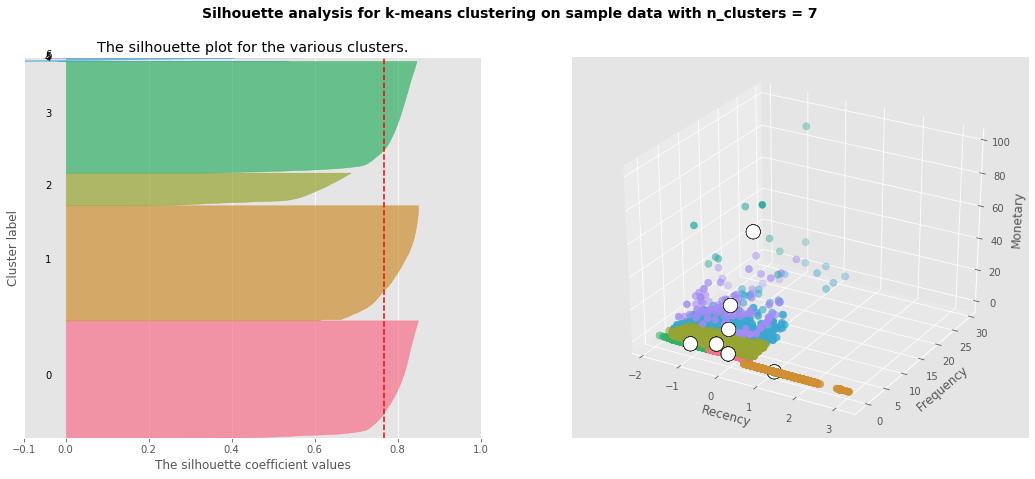

For n_clusters = 8 The average silhouette_score is : 0.7257695439146551


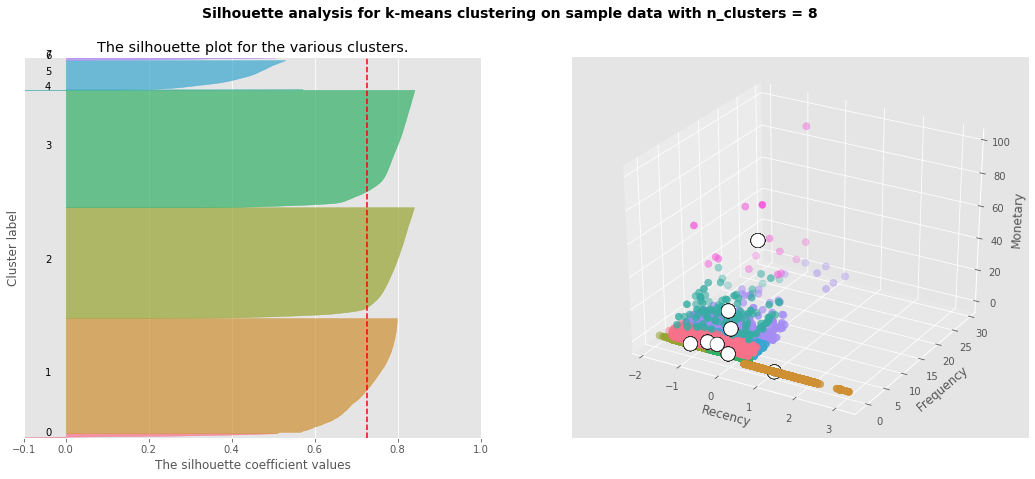

In [95]:
wcss_1 = wcss_clustering_rfm(rfm_std_1)

Les résultats ci-dessus présentent l'analyse de clustering pour différents nombres de clusters allant de 3 à 8.

La figure de gauche représente le coefficient de silhouette pour chacun des clusters, tandis que la largeur des bandes correspond à la taille des clusters.
A droite, il s'agit des résultats issus du clustering pour n_clusters fixé, dans l'espace RFM. 

Les conclusions sont les suivantes :

 - Quelque soit le nombre de clusters étudié, il y a toujours 1 ou plusieurs clusters qui présentent très peu d'individus.
 - Le nombre de clusters égale à 7 est donc le meilleur choix pour la métrique du score de silhouette.



In [ ]:
# Nombre de clusters à tester par l'algorithme de clustering
range_n_clusters = [3, 4, 5, 6, 7, 8]
# Affichage de l'intertie en fonction du nombre de clusters
plt.plot(range_n_clusters, wcss_1)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

La méthode Elbow n'est pas concluante, ce qui nous amène à séléctionner le nombre de clusters égale à 7 compte tenu de la maximisation du coefficient de silhouette comme vu précédemment

In [176]:
# Initilisation d'un KMeans
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0)
# Clustering sur les données pour la période 1
clusters = kmeans.fit_predict(X_transformed_1)
rfmTable_1['clusters'] = clusters

#### Résumé des résultats

In [177]:
# Liste des fonctions d'aggrégation
func = ['count', 'min', 'mean', 'median', 'max', 'std']

# Les données sont groupés par clusters
qtd_preco = rfmTable_1.groupby(['clusters'])

# Aggrégation des données
summery_table = qtd_preco['Recency', 'Frequency', 'Monetary'].agg(func)

# Affichage des résultats
summery_table

Recency                                         Frequency      \
           count  min        mean median  max        std     count min   
clusters                                                                 
0          29145    0  126.723692  127.0  205  45.166002     29145   1   
1          30096  365  483.039175  472.0  772  79.441749     30096   0   
2          30672  204  280.270083  278.0  364  45.319140     30672   1   
3             15   94  230.933333  237.0  347  86.307148        15   4   
4           8444   41  210.237802  211.0  364  87.582603      8444   1   
5            144   64  195.895833  186.5  359  85.647082       144   1   
6            925   49  209.395676  206.0  364  89.526213       925   1   

                                        Monetary                          \
              mean median max       std    count       min          mean   
clusters                                                                   
0         1.000103      1   2  0.010145    29145      9.59    137.803608   
1         0.000000      0   0  0.000000    30096      0.00      0.000000   
2         1.000000      1   1  0.000000    30672     11.63    133.214115   
3         9.933333     10  20  4.267262       15  14196.28  21868.114000   
4         2.077925      2   4  0.515394     8444     11.56    440.456367   
5         5.222222      5  14  2.584095      144   3583.20   5788.661389   
6         4.735135      4  24  2.376861      925     19.35   1425.478800   

                                           
            median       max          std  
clusters                                   
0            99.90   1117.99   129.076252  
1             0.00      0.00     0.000000  
2            97.43   1082.66   121.848617  
3         18384.75  44048.00  9017.365741  
4           305.12   2960.05   417.787003  
5          5243.89  12490.88  2092.313481  
6          1319.50   3617.37   900.883366

In [178]:
# Etiquettage des différents clusters
categories_2 = ['Top Clients ++',
                'Good Clients',
                'Potential Good Clients',
                'Average Clients',
                'Lost']

rfmTable_1.loc[rfmTable_1["clusters"] == 0, "clusters"] = 'Potential Good Clients'
rfmTable_1.loc[rfmTable_1["clusters"] == 1, "clusters"] = 'Lost'
rfmTable_1.loc[rfmTable_1["clusters"] == 2, "clusters"] = 'Average Clients'
rfmTable_1.loc[rfmTable_1["clusters"] == 3, "clusters"] = 'Top Clients ++'
rfmTable_1.loc[rfmTable_1["clusters"] == 4, "clusters"] = 'Good Clients'
rfmTable_1.loc[rfmTable_1["clusters"] == 5, "clusters"] = 'Top Clients ++'
rfmTable_1.loc[rfmTable_1["clusters"] == 6, "clusters"] = 'Top Clients ++'

- Les clusters 3, 5 et 6 possèdent un nombre d'individus très faibles par rapport aux autres. 

- De plus ils présentent des similarités, telles que des fréquences et montants très élevés par rapport aux autres

- Il semble donc judicieux de les fusioner pour n'en faire qu'un seul

Descriptifs du clustering des consommateurs :

- Top Clients ++ : Il s'agit des grands comptes, les individus dépensent très régulièrement des grandes quantitées d'argent

- Good Clients : Ils arrivent après les grandes comptes, les sommes d'argents dépensés sont conséquentes et la fréquence élevé

- Potential Good Clients : Ils dépensent moyennement et fréquemment, ils sont relativement nouveaux et ont un certain potentiel

- Average Clients : Ce sont les clients lambda, qui ont des scores moyens partout

- Lost : clients qui n'ont pas effectués d'achat cette année

In [171]:
# Calcul du nouveau score de silhouette
silhouette_avg = silhouette_score(rfm_std_1, rfmTable_1["clusters"])
print("Le nouveau score de silhouette_score est de :", silhouette_avg)

Le nouveau score de silhouette_score est de : 0.5339832143638565


In [179]:
# Nouvelle table de résumé du clustering
func = ['count', 'min', 'mean', 'median', 'max', 'std']
qtd_preco = rfmTable_1.groupby(['clusters'])
summery_table = qtd_preco['Recency', 'Frequency', 'Monetary'].agg(func)

# Affichage des résultats
summery_table

Recency                                          \
                         count  min        mean median  max        std   
clusters                                                                 
Average Clients          30672  204  280.270083    278  364  45.319140   
Good Clients              8444   41  210.237802    211  364  87.582603   
Lost                     30096  365  483.039175    472  772  79.441749   
Potential Good Clients   29145    0  126.723692    127  205  45.166002   
Top Clients ++            1084   49  207.900369    204  364  89.059077   

                       Frequency                                    Monetary  \
                           count min      mean median max       std    count   
clusters                                                                       
Average Clients            30672   1  1.000000      1   1  0.000000    30672   
Good Clients                8444   1  2.077925      2   4  0.515394     8444   
Lost                       30096   0  0.000000      0   0  0.000000    30096   
Potential Good Clients     29145   1  1.000103      1   2  0.010145    29145   
Top Clients ++              1084   1  4.871771      4  24  2.514809     1084   

                                                                            
                          min         mean   median       max          std  
clusters                                                                    
Average Clients         11.63   133.214115    97.43   1082.66   121.848617  
Good Clients            11.56   440.456367   305.12   2960.05   417.787003  
Lost                     0.00     0.000000     0.00      0.00     0.000000  
Potential Good Clients   9.59   137.803608    99.90   1117.99   129.076252  
Top Clients ++          19.35  2287.967565  1525.18  44048.00  3145.859972

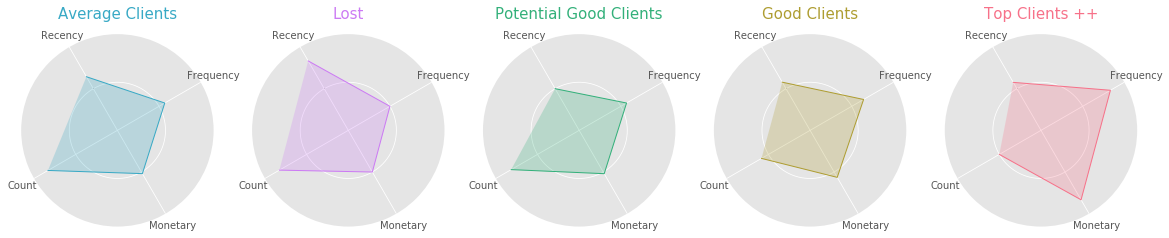

In [180]:
# Liste des couleurs pour chaque segment
palette_2 = sns.color_palette("husl", len(categories_2))
colors_2 = {label: color for label, color in zip(categories_2,
                                                 palette_2.as_hex())}
radar_plot(rfmTable_1, 'clusters', colors_2)

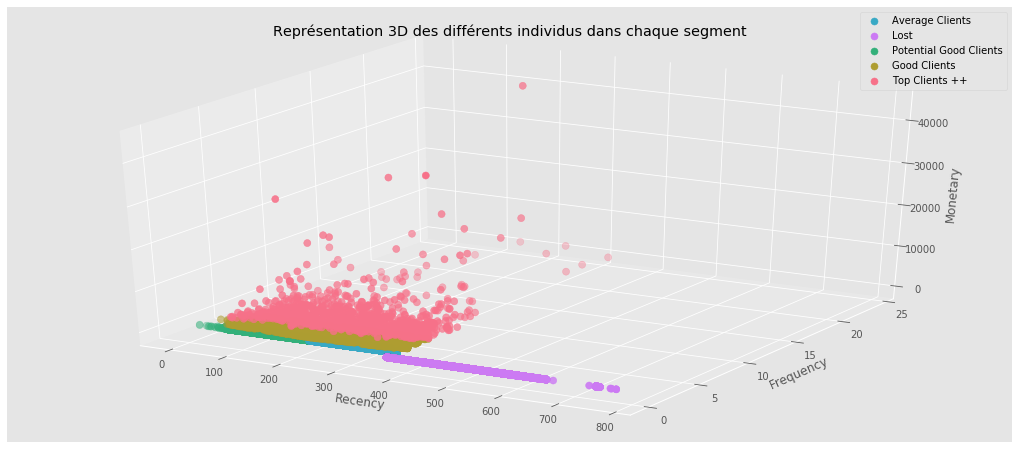

In [181]:
projection_3d_segments(rfmTable_1, 'clusters', colors_2)

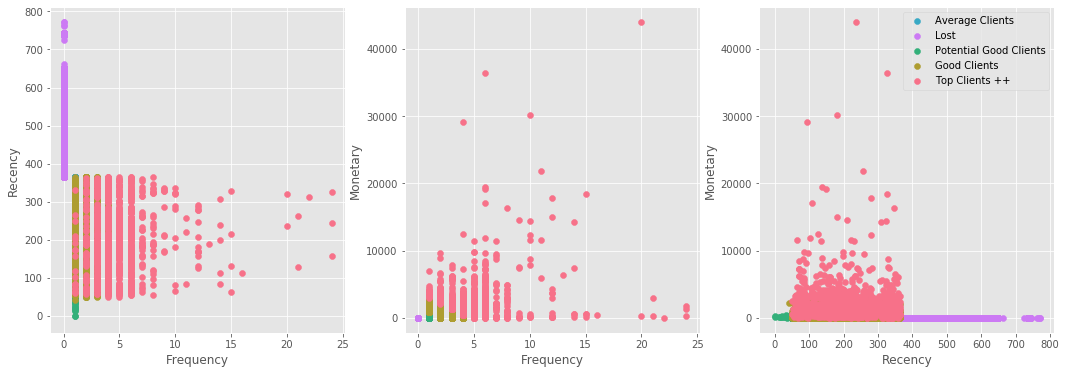

In [182]:
fig = plt.figure(1, figsize=(18, 6))

# Liste des couleurs pour chaque segment
sns.set_palette(sns.color_palette("husl", 5))
# 2D plot, Frequency vs Recency
plt.subplot(1, 3, 1)
projection_2d_segments(rfmTable_1,
                       "Frequency",
                       "Recency",
                       "clusters",
                       colors_2)

# 2D plot, Frequency vs Monetary
plt.subplot(1, 3, 2)
projection_2d_segments(rfmTable_1,
                       "Frequency",
                       "Monetary",
                       "clusters",
                       colors_2)

# 2D plot, Recency vs Monetary
plt.subplot(1, 3, 3)
projection_2d_segments(rfmTable_1,
                       "Recency", 
                       "Monetary",
                       "clusters",
                       colors_2)

plt.legend()
plt.show()

#### Snake plot pour comprendre et comparer les segments

#### Snake plot 


In [183]:
rfm_std_1['clusters'] = rfmTable_1['clusters']
rfm_std_1['RFM Score'] = rfmTable_1["RFM Score"]
rfm_std_1['customer_id'] = rfmTable_1["customer_id"]

# Melt the data into a long format so RFM values
# and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_std_1,
                   id_vars=['customer_id', 'RFM Score', 'clusters'],
                   value_vars=['Recency', 'Frequency', 'Monetary'],
                   var_name='Metric', value_name='Value')

# Affichage des 5 premières lignes
rfm_melt.head()

,customer_id,RFM Score,clusters,Metric,Value
0,00012a2ce6f8dcda20d059ce98491703,At Risk,Average Clients,Recency,0.306507
1,000161a058600d5901f007fab4c27140,Lost,Lost,Recency,1.093926
2,0001fd6190edaaf884bcaf3d49edf079,Lost,Lost,Recency,1.991974
3,0002414f95344307404f0ace7a26f1d5,About To Sleep,Lost,Recency,0.892190
4,000379cdec625522490c315e70c7a9fb,Recent Customers,Potential Good Clients,Recency,-0.598049


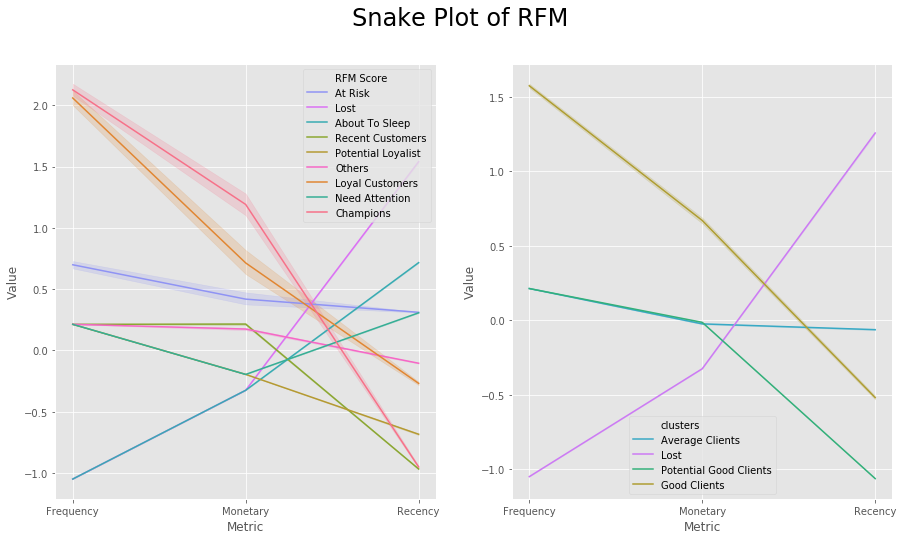

In [184]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# Snake plot de la segmentation manuelle
sns.set_palette(sns.color_palette("husl", 9))
sns.lineplot(x='Metric',
             y='Value',
             hue='RFM Score',
             data=rfm_melt,
             ax=ax1,
             palette=colors_1)


# Snake plot du clustering par K-Means
sns.set_palette(sns.color_palette("husl", 5))
sns.lineplot(x='Metric',
             y='Value',
             hue='clusters',
             data=rfm_melt[~rfm_melt["clusters"].isin(["Top Clients ++"])],
             ax=ax2,
             palette=colors_2)

plt.suptitle("Snake Plot of RFM", fontsize=24)  # make title fontsize subtitle
plt.show()

- Les catégories "Lost" et "About to Sleep" correspondent au cluster "Lost"

- Les catégories "Champions" et "Loyal Customers" correspondent au cluster "Potential Good Clients"

- Quant aux autres catégories, la méthodologie 1 offre une segmentation plus nombreuse en discernant plus de catégories de consommateurs



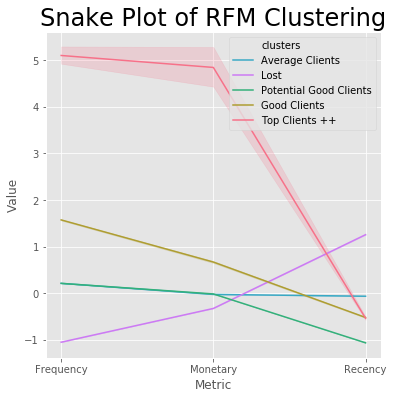

In [185]:
# a snake plot with K-Means
fig = plt.figure(1, figsize=(6, 6))

sns.lineplot(x='Metric',
             y='Value',
             hue='clusters',
             data=rfm_melt,
             palette=colors_2)

plt.title("Snake Plot of RFM Clustering", fontsize=24)  # make title fontsize subtitle
plt.legend(loc='upper right')
plt.show()

- Comme le montre le graphique ci-dessus, le clustering permet de grouper les "grands comptes", qui nécessitent probablement un traitement spécifique

## 4. Stabilité des segmentations

Pour analyser la stabilité des segments au cours du temps, nous allons simplement réitéré les étapes précédentes sur des périodes décalés dans l'année de 30 jours, 60 jours et 90 jours. Il s'agira ensuite de déterminer la stabilité par l'indice de Rand.

### 4.1 Calcul RFM pour les 3 périodes étudiées 

In [187]:
def calculRfmTable(data, period, end_period):

    """
    Calcul des valeurs R, F et M et assigne pour chaque client
    un score selon la méthodologie 1 et un cluster selon la méthodologie 2

    Paramètres:
    data(pd.DataFrame): DataFrame avec 3 colonnes
    Recency, Frequency et Monetary
    period(int) : Nombre de jours
    end_period(dt.datetime): Date de fin de période

    Return:
    rfmTable(pd.DataFrame): DataFrame data avec 2 nouvelles colonnes
    correspondant
    aux scores et clusters des différents clients pour les méthodologies 1 et 2

    """

    rfm = calculateRFM(data, period, end_period)
    # Calcul le quantile associé à chaque variable RFM
    # pour chaque client
    rfmTable = calculQuantile(rfm)
    # Determine pour chaque client le segment auquel il appartient
    # suivant ses quantiles pour les variables R, F et M
    rfmTable["RFM Score"] = rfmTable.apply(calculSegment, axis=1)

    # Normalise les valeurs R, F et M pour le clustering
    X_transformed = encoder.transform(rfm[["Recency",
                                           "Frequency", "Monetary"]])
    # Clustering pour chacun des clients
    clusters = kmeans.predict(X_transformed)
    rfmTable["clusters"] = clusters
    
    # Etiquettage et fusion de 3 clusters
    rfmTable.loc[rfmTable["clusters"] == 0, "clusters"] = 'Potential Good Clients'
    rfmTable.loc[rfmTable["clusters"] == 1, "clusters"] = 'Lost'
    rfmTable.loc[rfmTable["clusters"] == 2, "clusters"] = 'Average Clients'
    rfmTable.loc[rfmTable["clusters"] == 3, "clusters"] = 'Top Clients ++'
    rfmTable.loc[rfmTable["clusters"] == 4, "clusters"] = 'Good Clients'
    rfmTable.loc[rfmTable["clusters"] == 5, "clusters"] = 'Top Clients ++'
    rfmTable.loc[rfmTable["clusters"] == 6, "clusters"] = 'Top Clients ++'

    return rfmTable

In [188]:
# Calcul RFM avec la même méthode,
# mais pour une période décalé de 30 jours en arrière
rfmTable_2 = calculRfmTable(data, period, today - timedelta(days=30))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 90 jours en arrière
rfmTable_3 = calculRfmTable(data, period, today - timedelta(days=60))

# Calcul RFM avec la même méthode,
# mais pour une période décalé de 180 jours en arrière
rfmTable_4 = calculRfmTable(data, period, today - timedelta(days=90))

C:\Users\maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [189]:
# Sauvegarde des DataFrames RFM
save = True
if save :
    rfmTable_1.to_pickle('rfm_period_1.df')
    rfmTable_2.to_pickle('rfm_period_2.df')
    rfmTable_3.to_pickle('rfm_period_3.df')
    rfmTable_4.to_pickle('rfm_period_4.df')

In [190]:
# Lecture des DataFrames RFM
load = False
if load :
    rfmTable_1 = pd.read_pickle('rfm_period_1.df')
    rfmTable_2 = pd.read_pickle('rfm_period_2.df')
    rfmTable_3 = pd.read_pickle('rfm_period_3.df')
    rfmTable_4 = pd.read_pickle('rfm_period_4.df')

### 4.2 Calcul de la stabilité ARI : Adjusted Rand Index

In [191]:
def stability_segments(rfmTable_ref, *rfmTable_):

    """
    Détermine la stabilité des segments suivant les 2 méthodologies
    vu précédemment
    La stabilité est défini comme le pourcentage d'individus restant
    dans le même segment d'une période à l'autre

    Paramètres:
    rfm_ref(pd.DataFrame): Segmentzation pendant la période de référence
    *rfm_(pd.DataFrame) :  Différentes segmentations correspondant
    à différentes périodes

    Return:
    df_results(pd.DataFrame): DataFrame de résultats de stabilité
    """

    stability_clusters = []
    stability_segments = []

    # Pour chaque segmentation
    for rfmTable in rfmTable_:
        
        # Calcul de la stabilité pour la segmentation par quantile
        stability_segments.append(
            round(100 * adjusted_rand_score(rfmTable_ref["RFM Score"],
                                rfmTable["RFM Score"]), 2))
        
        # Calcul de la stabilité pour la segmentation par clustering
        stability_clusters.append(
            round(100 * adjusted_rand_score(rfmTable_ref["clusters"],
                                          rfmTable["clusters"]), 2))

    # Concaténation des résultats des 2 méthodologies
    results = np.c_[stability_segments, stability_clusters]

    # Converti les données en DataFrame
    df_results = pd.DataFrame(results,
                              columns=["RFM Score", "Clusters"]
                              ).rename_axis("ARI (%)", axis=1)

    return df_results

In [192]:
# Calcul de la stabilité des segments et des clusters
stability = stability_segments(rfmTable_1,
                               rfmTable_2,
                               rfmTable_3,
                               rfmTable_4)
# L'index est étiquetté selon les différentes périodes
stability.index = ['30 jours', '60 jours', '90 jours']
# Affichage des résultats
stability

ARI (%),RFM Score,Clusters
30 jours,90.20,72.16
60 jours,84.39,53.96
90 jours,70.63,43.75


La stabilité des deux méthodes étant bien différente, la fréquence à laquelle il est souhaitable de faire une maintenance dépend de la méthodologie choisie. Pour la méthodologie traditionelle, une maintenance tous les 90 jours suffit, alors que pour la méthode du clustering, une mise à jour tous les 30 jours est nécesssaire.

### 4.3 Sankey diagrammes

Un diagramme de Sankey est un type de diagramme de flux dans lequel la largeur des flèches est proportionelle au flux représenté. Il permet de représenter les flux d'individus qui passent d'un segment à l'autre pour les périodes étudiés. Les diagrammes de Sankey permettent donc dans ce cas de figure, de représenter la stabilité temporelle des segmentations.

Plus d'informations sur la construction des diagrammes de Sankey : https://plot.ly/python/sankey-diagram/

In [193]:
def sankey_data(method, *rfm):

    """
    La fonction sankey_data retourne un dictionnaire adapté au tracé
    d'un diagramme de Sankey
    Plus d'informations : https://plot.ly/python/sankey-diagram/

    Paramètres :
    method: Nom de la colonne dont les informations sont à récupérer
    *rfm: Au moins 2 DataFrame correspondant à des segmentations
    temporellement différentes

    Return :

    dict: Dictionnaire de résultats

    """

    sources = []
    targets = []
    values = []
    sankey_data = {}

    list_segments = []
    list_segments_0 = []
    list_segments_1 = []

    sankey_data["label"] = sorted(list(rfm[0][method].unique()))
    source = 0
    target = 0
    i = 0

    while i < len(rfm)-1:

        list_segments_0 = sorted(list(rfm[i][method].unique()))
        list_segments_1 = sorted(list(rfm[i + 1][method].unique()))

        list_segments.append(list_segments_1)

        sankey_data["label"] += list_segments_1

        target += len(list_segments_0)
        for segment_0 in list_segments_0:
            for segment_1 in list_segments_1:

                sources.append(list_segments_0.index(segment_0) + source)
                targets.append(list_segments_1.index(segment_1) + target)

                flow = sum(rfm[i + 1].iloc[rfm[i][rfm[i][method] ==
                           segment_0].index][method] == segment_1)

                values.append(flow)

        source += len(list_segments_0)
        i += 1

    sankey_data["source"] = sources
    sankey_data["target"] = targets
    sankey_data["value"] = values

    return sankey_data

#### 4.3.1 Méthodologie 1 : Segmentation par quantile

In [194]:
# Calcul les données pour le diagramme de Sankey pour la segmentation
sankey_data_1 = sankey_data('RFM Score',
                            rfmTable_1,
                            rfmTable_2,
                            rfmTable_3,
                            rfmTable_4)

# Associe les couleurs correspondantes aux segments
sankey_data_1["colors"] = [colors_1[label] for label in sankey_data_1["label"]]

In [195]:
# Affiche le diagramme de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
              pad=15,
              thickness=20,
              line=dict(color="black", width=0.1),
              label=sankey_data_1["label"],
              color=sankey_data_1["colors"]  # colors for each label
    ),
    link=dict(
              source=sankey_data_1["source"],  # indices correspond to labels
              target=sankey_data_1["target"],
              value=sankey_data_1["value"]
    ),
)])

fig.update_layout(title_text="Evolution temporelle des clients"
                             " dans chaque segment",
                  font_size=10)
fig.show()

La colonne de gauche correspond à une photo des clients à la date t0. La deuxième, troisème et quatrième colonne correspondent respectivement aux dates t0 + 30 jours, t0 + 60 jours, t0 + 90 jours 

#### 4.3.2 Méthodologie 2 : Clustering

In [196]:
# Calcul les données pour le diagramme de Sankey pour le clustering
sankey_data_2 = sankey_data('clusters',
                            rfmTable_1,
                            rfmTable_2,
                            rfmTable_3,
                            rfmTable_4)

# Ajout des couleurs correspondantes aux labels clusters
sankey_data_2["colors"] = [colors_2[label] for label in sankey_data_2["label"]]

In [197]:
# Affiche le diagramme de Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
              pad=15,
              thickness=20,
              line=dict(color="black", width=0.1),
              label=sankey_data_2["label"],
              color=sankey_data_2["colors"]
    ),
    link=dict(
              source=sankey_data_2["source"],  # indices correspond to labels
              target=sankey_data_2["target"],
              value=sankey_data_2["value"]
    ),
)])

fig.update_layout(title_text="Evolution temporelle des clients"
                             "dans chaque cluster",
                  font_size=10)
fig.show()

De la même manière que pour la segmentation par le score RFM, la colonne de gauche correspond à une photo des clients à la date t0. La deuxième, troisème et quatrième colonne correspondent respectivement aux dates t0 + 30 jours, t0 + 60 jours, t0 + 90 jours 